In [ ]:
#Pipeline pt.1
import os
import math
import numpy as np
import pandas as pd
import skimage.io
import skimage.filters
import skimage.measure


def nan_append(x_pos, y_pos, centroids, intensity, area, speeds):
    x_pos.append(np.nan)
    y_pos.append(np.nan)
    centroids.append((np.nan, np.nan))
    intensity.append(np.nan)
    area.append(np.nan)
    speeds.append(np.nan)

def calculate_speed(prev_x, prev_y, curr_x, curr_y, time):
    deltax = curr_x - prev_x
    deltay = curr_y - prev_y
    speed = 1.6176 * np.sqrt(deltax**2 + deltay**2) / time
    return speed

def mKate_analysis_pipeline(total_num_worms, dead_worms, time):
    #Retrieving number of worms
    num_worms = math.sqrt(total_num_worms)
        if num_worms != int(num_worms)
            return "invalid number of total worms"
        
    
    # Extracting all necessary files from the current directory
    name = 'Mono1.tif'
    tiff_files = [file for file in os.listdir('.') if file.endswith(name)]
    if not tiff_files:
        raise FileNotFoundError('No Matching File Found')
    
    # Variables to hold previous positions for speed calculation
    prev_x_pos = None
    prev_y_pos = None
    
    for file in tiff_files:
        # Variable declaration
        x_pos = []
        y_pos = []
        centroids = []
        intensity = []
        area = []
        speeds = []
        
        # Get Image
        dead_worm_image = skimage.io.imread(file)

        # Calculate Otsu threshold for the entire image
        my_otsu_threshold = skimage.filters.threshold_otsu(dead_worm_image) - 30

        # Calculating Dimensions, padding and padded image
        height, width = dead_worm_image.shape
        pad_height = (num_worms - height % num_worms) % num_worms
        pad_width = (num_worms - width % num_worms) % num_worms
        padded_image = np.pad(dead_worm_image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

        # Image split into subsections and running through each subsection
        subsections = [np.hsplit(h, num_worms) for h in np.vsplit(padded_image, num_worms)]

        # Loop through the 25 subsections
        for k in range(num_worms):
            for p in range(num_worms):
                current_index = num_worms * k + p + 1
                
                # DEAD WORM ALERT
                if current_index in dead_worms:
                    nan_append(x_pos, y_pos, centroids, intensity, area, speeds)
                    continue

                worm = subsections[k][p]
                # Create a binary mask using Otsu's threshold
                labeled_foreground = (worm > my_otsu_threshold).astype(int)

                # Label the connected components in the binary mask
                labeled_mask = skimage.measure.label(labeled_foreground)
                properties = ['centroid', 'area', 'intensity_mean']
                my_regions = skimage.measure.regionprops_table(labeled_mask, intensity_image=worm, properties=properties)
                regions_df = pd.DataFrame(my_regions)

                if regions_df.empty:
                    nan_append(x_pos, y_pos, centroids, intensity, area, speeds)
                    continue

                # Append numerical values instead of Series
                area.append(regions_df['area'].values[0])
                xpos = round(regions_df['centroid-0'].values[0], 1)
                ypos = round(regions_df['centroid-1'].values[0], 1)
                centroids.append([xpos, ypos])
                x_pos.append(xpos)
                y_pos.append(ypos)
                intensity.append(round(regions_df['intensity_mean'].values[0], 1))
                
                # Calculate speed
                if prev_x_pos is not None and prev_y_pos is not None:
                    speed = calculate_speed(prev_x_pos[current_index-1], prev_y_pos[current_index-1], xpos, ypos, time)
                    speeds.append(speed)
                else:
                    speeds.append(np.nan)

        # Save the current positions for the next iteration
        prev_x_pos = x_pos
        prev_y_pos = y_pos

    # Print collected data
    print("Centroids:", centroids)
    print("X Positions:", x_pos)
    print("Y Positions:", y_pos)
    print("Intensities:", intensity)
    print("Areas:", area)
    print("Speed:", speeds)
    
    # Save results to files
    np.savetxt('x_positions.txt', x_pos, fmt='%s')
    np.savetxt('y_positions.txt', y_pos, fmt='%s')
    np.savetxt('centroids.txt', np.array(centroids, dtype=object), fmt='%s')
    np.savetxt('speeds.txt', speeds, fmt='%s')

    
# Example usage
time = 0.5
total_num_worms = 25  # Assuming a 5x5 grid
dead_worms = [1, 6, 11, 16, 21]  # Example list of dead worm indices
mKate_analysis_pipeline(total_num_worms, dead_worms, time)



In [42]:
#Pipeline pt.2 
        
#function declarations 

#remove blob removes extra blobs aside from the desired neurite 
def removeBlobs(original_image, labeled_image):
    objects = skimage.measure.regionprops(labeled_image)
    object_areas = [obj["area"] for obj in objects]
    object_max = max(object_areas)        
    small_objects =[obj for obj in objects if obj.area != object_max]
    for i in small_objects:
        original_image[i.bbox[0]:i.bbox[2], i.bbox[1]:i.bbox[3]] = 0

#appending nan to arrays
def nan_append(x_pos, y_pos, centroids, intensity, area, speeds):
    x_pos.append(np.nan)
    y_pos.append(np.nan)
    centroids.append((np.nan, np.nan))
    intensity.append(np.nan)
    area.append(np.nan)
    speeds.append(np.nan)
    

def calculate_speed(prev_x, prev_y, curr_x, curr_y, time):
    deltax = curr_x - prev_x
    deltay = curr_y - prev_y
    speed = 1.6176 * np.sqrt(deltax**2 + deltay**2) / time
    return speed

    
    
    
    
    
    
    
    

# Variable declaration
dead_worms = [5, 8, 16, 17, 21, 25]
area = []
centroids = []
x_pos = []
y_pos = []
orientation = []
major_axis = []
minor_axis = []
mKate_intensity = []
gCamp_mean_intensity = []

# Get image
input1 = skimage.io.imread('240517_PHX9249_T0001_Mono1.tif')
input2 = skimage.io.imread('240517_PHX9249_T0001_Mono.tif')
mono1 = input1.copy()
mono = input2.copy()

# Decided that creating the binary mask per individual frame makes more sense instead of creating it before

# Get Dimension, calculate padding and padded image
mono1_height, mono1_width = mono1.shape
mono1_pad_height = (5 - mono1_height % 5) % 5
mono1_pad_width = (5 - mono1_width % 5) % 5
mono1_padded_image = np.pad(mono1, ((0, mono1_pad_height), (0, mono1_pad_width)), mode='constant', constant_values=0)

mono_height, mono_width = mono.shape
mono_pad_height = (5 - mono_height % 5) % 5
mono_pad_width = (5 - mono_width % 5) % 5
mono_padded_image = np.pad(mono, ((0, mono_pad_height), (0, mono_pad_width)), mode='constant', constant_values=0)


# Image split into subsections and running through each subsection
# Vsplit for sub arrays 
mono1_subsections = [np.hsplit(h, 5) for h in np.vsplit(mono1_padded_image, 5)]
mono_subsections = [np.hsplit(h, 5) for h in np.vsplit(mono_padded_image, 5)]

# Loop through the 25 subsections
for k in range(5):
    for p in range(5):
        current_index = 5 * k + p + 1
        
        if current_index in dead_worms:
            print("DEAD WORM ALERT \n")
            area.append(np.nan)
            centroids.append((np.nan, np.nan))
            x_pos.append(np.nan)
            y_pos.append(np.nan)
            mKate_intensity.append(np.nan)
            gCamp_intensity.append(np.nan)
            continue
        
        mKate = mono1_subsections[k][p].copy()
        gCamp = mono_subsections[k][p].copy()
        
        # Create a binary mask using Otsu's threshold
        mKate_image = mKate > mono1_otsu_threshold
        gCamp_image = gCamp > mono1_otsu_threshold    
                
        labeled_mask = skimage.measure.label(mKate_image)
        properties = ['centroid', 'area', 'intensity_mean', 'orientation', 'axis_major_length', 'axis_minor_length']
        my_regions = skimage.measure.regionprops_table(labeled_mask, intensity_image=worm, properties=properties)
        regions_df = pd.DataFrame(my_regions)
        
        orientation = regions_df['orientation'].iloc[0]
        major_axis = regions_df['axis_major_length'].iloc[0]
        minor_axis = regions_df['axis_minor_length'].iloc[0]

        #extracting neurite frame
        xpos = int(round(regions_df['centroid-0'].values[0], 1))
        ypos = int(round(regions_df['centroid-1'].values[0], 1))
        neurite_frame = mKate[xpos-20:xpos+20, ypos-20:ypos+20]
        
        #creating identical frame of the image with gCamp 
        gCamp_frame = gCamp[xpos-20:xpos+20, ypos-20:ypos+20]
        plt.imshow(gCamp_frame, cmap = 'gray')
        plt.title(f'gCamp frame {current_index}')
        plt.colorbar()
        plt.show()  
        
        
        #applying gaussian filter to fatten image
        #taking the top 97.2 percentile and making them completely white
        #changing the contrast of the image to make dark spots later 
        #creating binary mask and filling in any holes in the mask 
        smooth = filters.gaussian(neurite_frame, sigma=0.9)
        percentiles = np.percentile(smooth, (2.5, 97.5))
        scaled = exposure.rescale_intensity(smooth, in_range=tuple(percentiles))
        threshold = filters.threshold_otsu(scaled)
        thresh = scaled > threshold 
        neurite = ndi.binary_fill_holes(thresh)

        plt.imshow(neurite_frame, cmap = 'gray', vmax = np.percentile(image, 95))
        plt.title(f'Neurite Cross_section {current_index}')
        plt.colorbar()
        plt.show()  
        
        #labeling chunks and leaving the biggest chunk
        #'labeled_image' is the image with detected objects  
        #'count' is the number of objects
        labeled_image, count = skimage.measure.label(thresh, return_num=True)   
        if count > 1: 
            removeBlobs(neurite, labeled_image)
        
        plt.imshow(neurite, cmap = 'gray')
        plt.title("fill")
        plt.show()
    
        #New centroid will always be at position 20,20 
        
        #Removing cell body from mKate image
        #Performing same operation of removing extra blobs
        neurite[16:24, 16:24] = 0
        labeled_image, count = skimage.measure.label(neurite, return_num=True)   
        if count > 1: 
            removeBlobs(neurite, labeled_image)
        
        
        plt.imshow(neurite, cmap = 'gray')
        plt.title("whiteout")
        plt.show()
        
        
        #gCamp with new mask of only cell body 
        #Calculating the mean intensity over this region
        cell_body_overlay = gCamp_frame * neurite
        label_cell_body_overlay = measure.label(cell_body_overlay)
        props = measure.regionprops_table(label_cell_body_overlay, cell_body_overlay, properties=['intensity_mean'])
        gCamp_mean_intensity.append(round(props['intensity_mean'].mean(), 1))

        
        plt.imshow(cell_body_overlay, cmap = 'gray')
        plt.title("whiteout")
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dklee/Documents/Bringmann_Lab/240517_PHX9249_T0001_Mono1.tif'

In [2]:
#imports 
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.filters
import skimage.measure

# from skimage import exposure
# from skimage import measure
# from skimage import color, morphology

from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.segmentation import active_contour
from skimage.draw import polygon_perimeter
import plotly.io
import plotly.express as px
from scipy import ndimage as ndi

from skimage import filters, measure, morphology, segmentation, color, exposure


working on file1 and monos1,1
DEAD WORM ALERT 1 

working on file1 and monos1,2
Subsection 2:
   centroid-0  centroid-1  intensity_mean
0     102.875      83.875         562.375


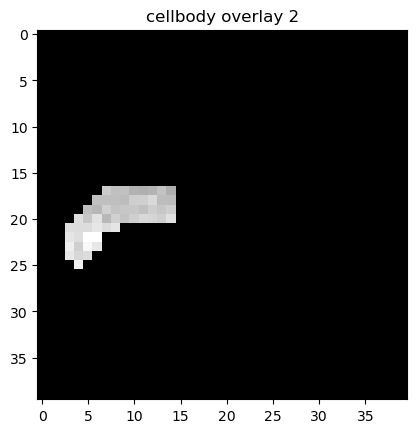

working on file1 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.0        41.0      511.444444


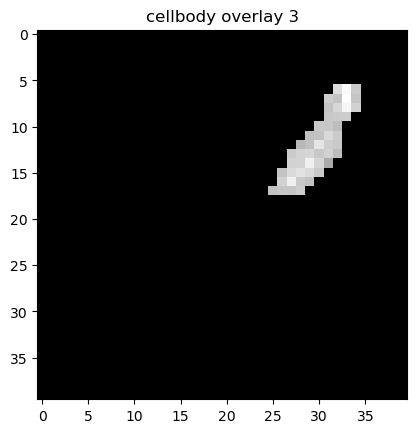

working on file1 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0        74.2        73.5           485.9


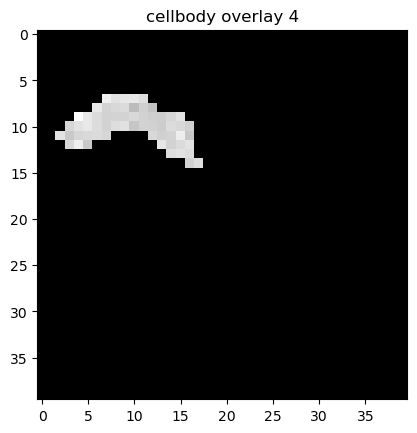

working on file1 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        29.0        67.0           283.0


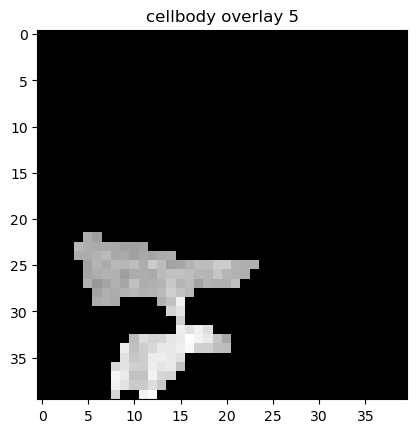

working on file1 and monos2,1
DEAD WORM ALERT 6 

working on file1 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0        73.0       112.5           458.8


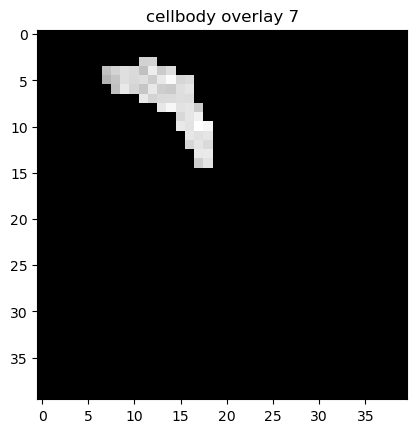

working on file1 and monos2,3
working on file1 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0      96.875     106.875         396.625


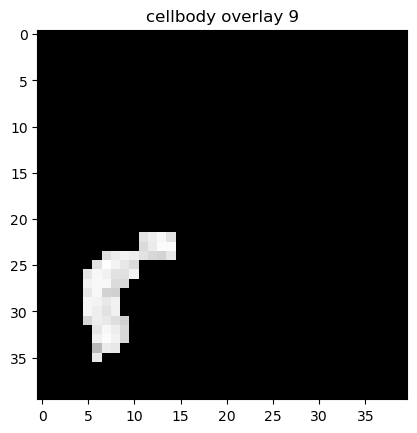

working on file1 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0      61.125     104.125          562.25


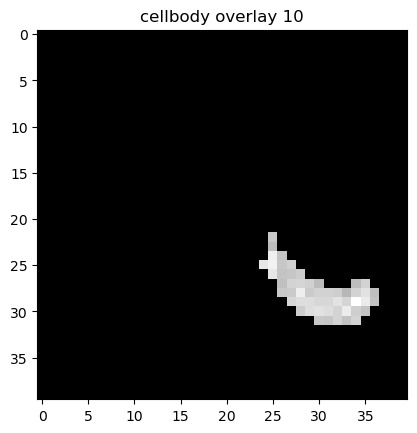

working on file1 and monos3,1
DEAD WORM ALERT 11 

working on file1 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0     103.875      53.875         408.375


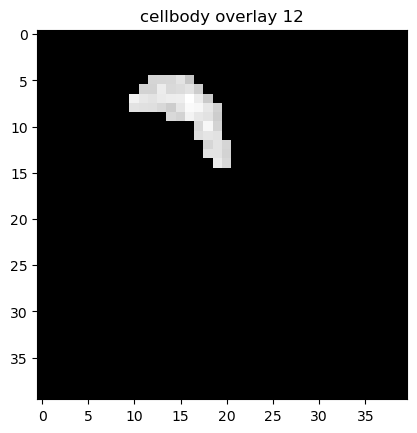

working on file1 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0   79.555556  118.333333      454.222222


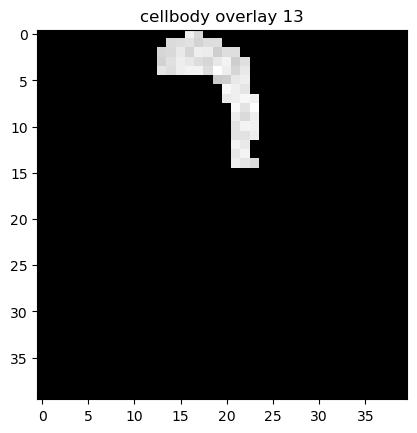

working on file1 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0  108.090909   97.636364      617.181818


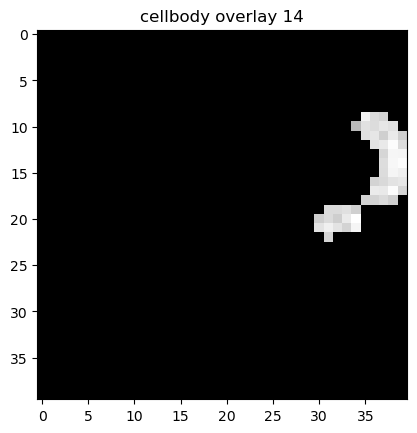

working on file1 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0        36.0        88.8           457.7


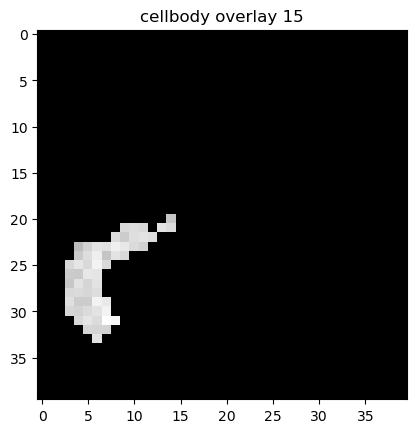

working on file1 and monos4,1
DEAD WORM ALERT 16 

working on file1 and monos4,2
working on file1 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0   39.357143   72.214286      384.357143


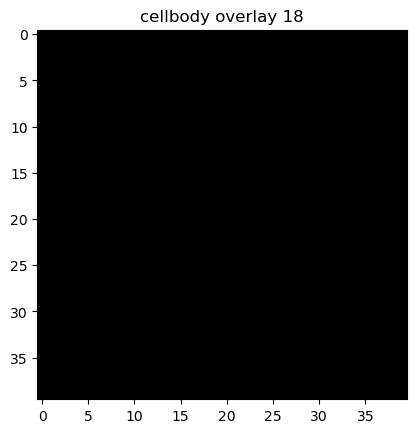

working on file1 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0   85.615385   90.384615      350.769231


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


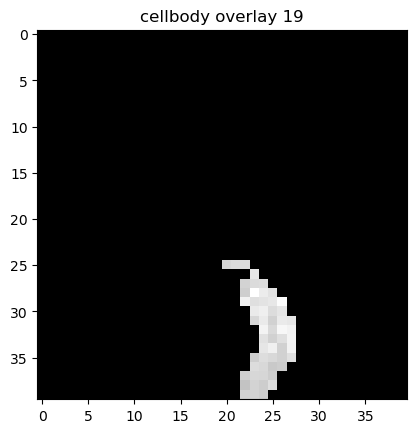

working on file1 and monos4,5
working on file1 and monos5,1
DEAD WORM ALERT 21 

working on file1 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0   65.363636  121.909091      515.636364


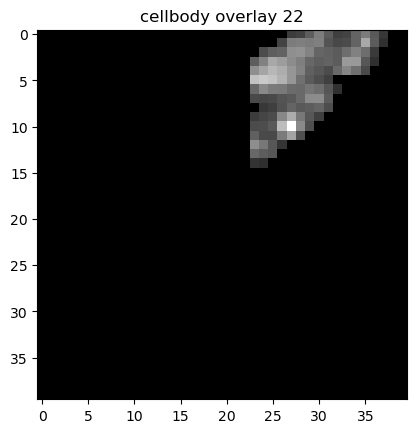

working on file1 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0     55.8125      76.875           403.0


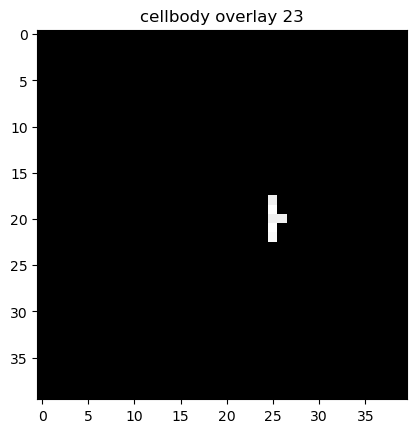

working on file1 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.714286        80.5      540.857143


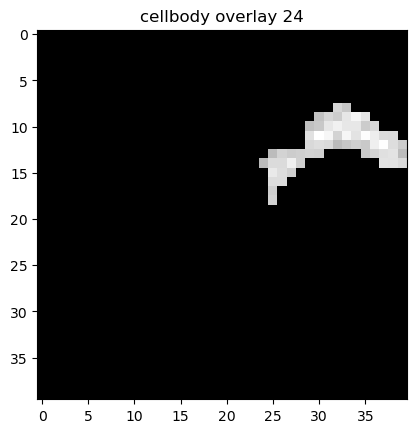

working on file1 and monos5,5
Centroids: [(nan, nan), [102, 83], [44, 41], [74, 73], [29, 67], (nan, nan), [73, 112], (nan, nan), [96, 106], [61, 104], (nan, nan), [103, 53], [79, 118], [108, 97], [36, 88], (nan, nan), (nan, nan), [39, 72], [85, 90], (nan, nan), (nan, nan), [65, 121], [55, 76], [44, 80], (nan, nan)]
X Positions: [nan, 102, 44, 74, 29, nan, 73, nan, 96, 61, nan, 103, 79, 108, 36, nan, nan, 39, 85, nan, nan, 65, 55, 44, nan]
Y Positions: [nan, 83, 41, 73, 67, nan, 112, nan, 106, 104, nan, 53, 118, 97, 88, nan, nan, 72, 90, nan, nan, 121, 76, 80, nan]
mKate Intensities: [nan, 562.4, 511.4, 485.9, 283.0, nan, 458.8, nan, 396.6, 562.2, nan, 408.4, 454.2, 617.2, 457.7, nan, nan, 384.4, 350.8, nan, nan, 515.6, 403.0, 540.9, nan]
gCamp Intensities: [nan, 163.8, 195.2, 177.2, 209.0, nan, 177.3, nan, 188.5, 183.4, nan, 194.6, 185.3, 191.9, 176.8, nan, nan, nan, 177.2, nan, nan, 524.0, 175.7, 185.0, nan]
Speed: [nan, nan, 231.67285045321992, 141.90695061539444, 146.87237909641144

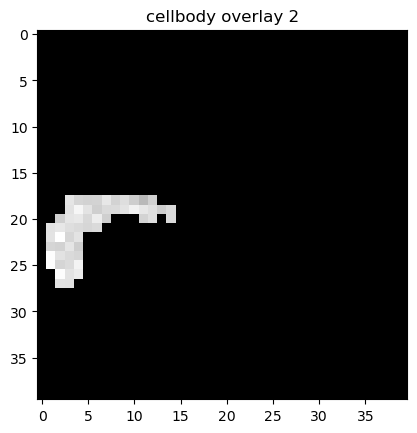

working on file2 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        43.5   41.333333      456.583333


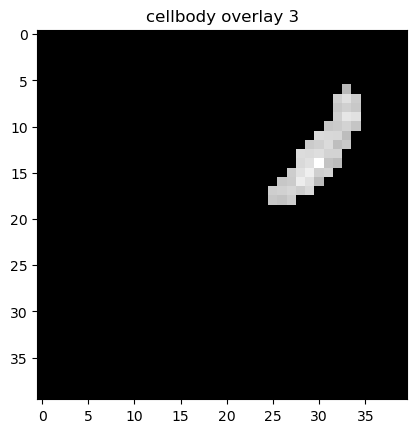

working on file2 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   67.454545   71.636364           448.0


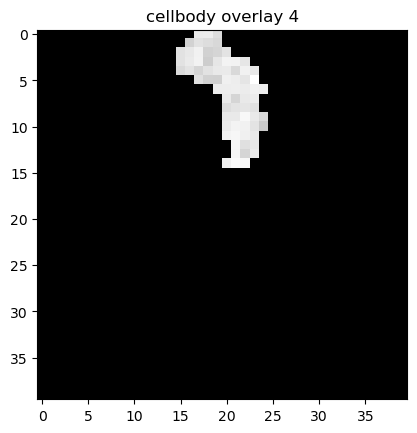

working on file2 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        29.0        67.0           285.0
1        31.0        69.0           278.0


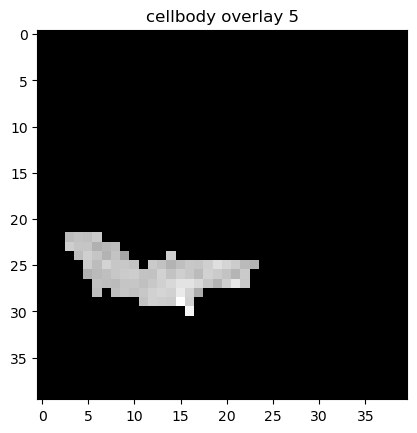

working on file2 and monos2,1
DEAD WORM ALERT 6 

working on file2 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0   65.545455  101.181818      439.363636


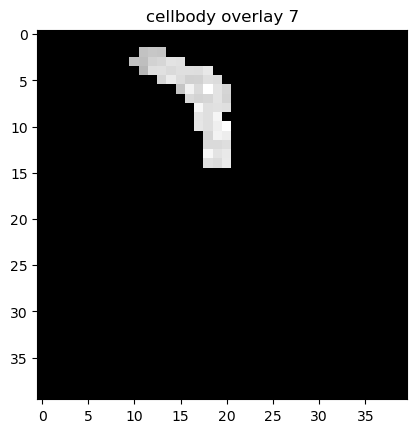

working on file2 and monos2,3
working on file2 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0        96.5       107.0         416.625


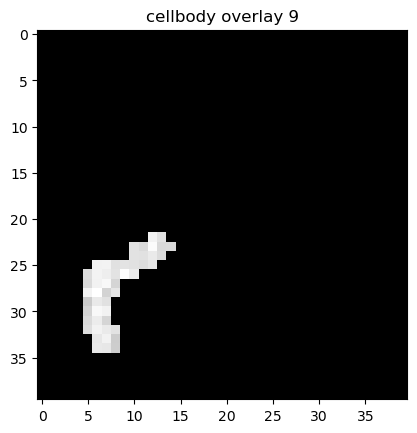

working on file2 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0   60.888889  104.111111           530.0


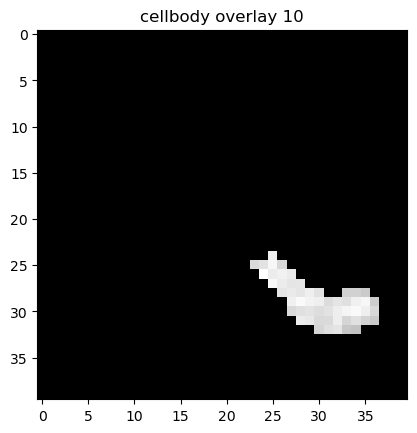

working on file2 and monos3,1
DEAD WORM ALERT 11 

working on file2 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0     103.875      53.875         401.625


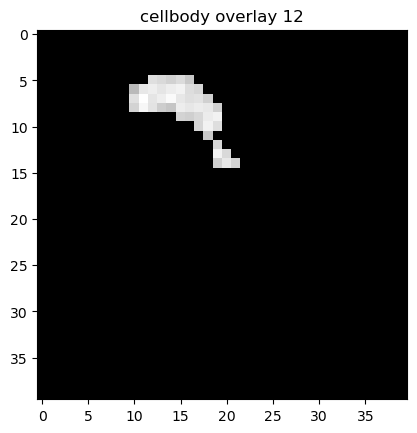

working on file2 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0   83.666667  118.111111           445.0


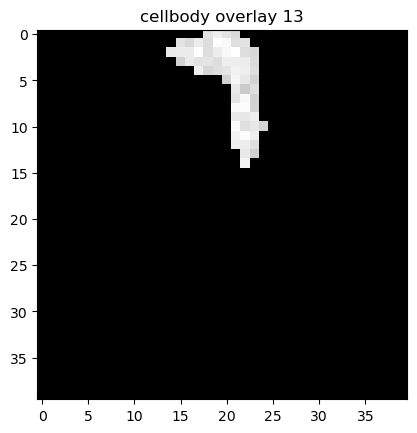

working on file2 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0  108.090909   97.636364      624.272727


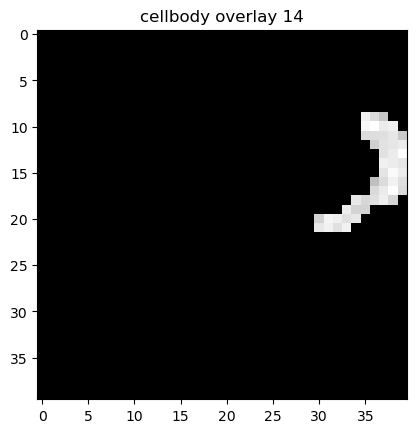

working on file2 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0      36.875      86.125           489.0


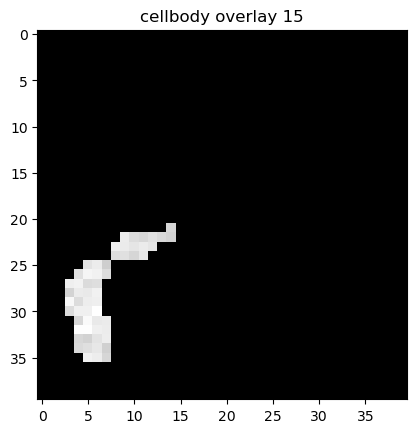

working on file2 and monos4,1
DEAD WORM ALERT 16 

working on file2 and monos4,2
working on file2 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0   39.384615   71.769231      395.384615


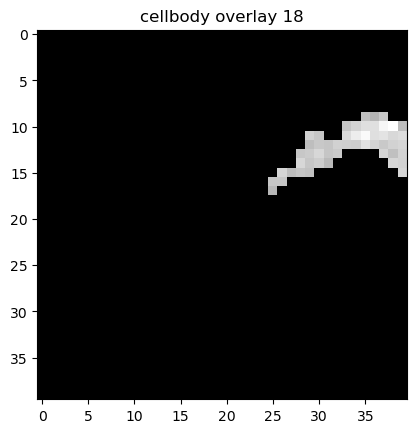

working on file2 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0        92.2        86.0           406.7


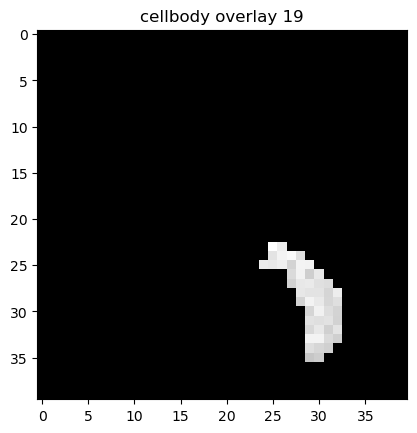

working on file2 and monos4,5
working on file2 and monos5,1
DEAD WORM ALERT 21 

working on file2 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0        64.5       122.5      504.083333


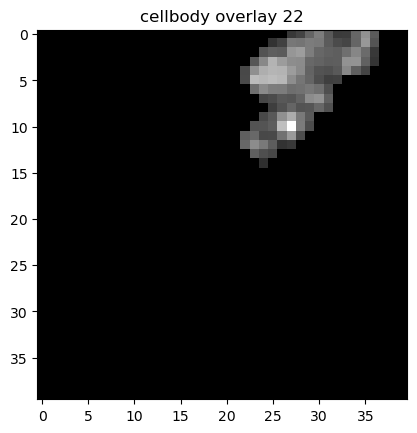

working on file2 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0   34.857143   58.928571      355.285714


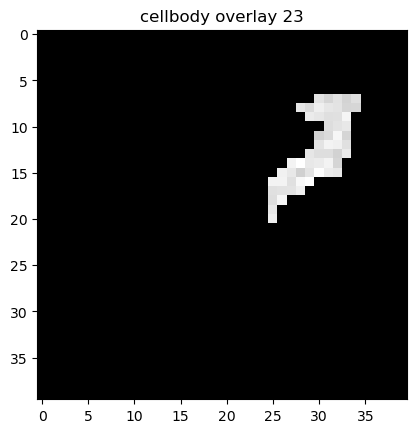

working on file2 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.733333   80.666667      520.266667


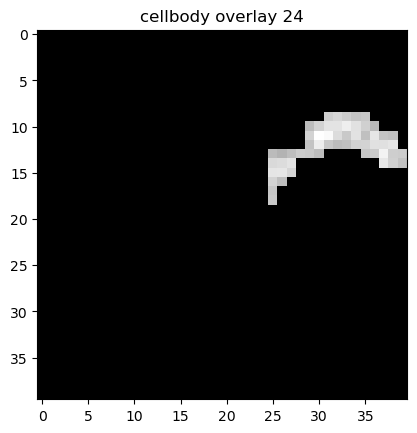

working on file2 and monos5,5
Centroids: [(nan, nan), [98, 88], [43, 41], [67, 71], [29, 67], (nan, nan), [65, 101], (nan, nan), [96, 107], [60, 104], (nan, nan), [103, 53], [83, 118], [108, 97], [36, 86], (nan, nan), (nan, nan), [39, 71], [92, 86], (nan, nan), (nan, nan), [64, 122], [34, 58], [44, 80], (nan, nan)]
X Positions: [nan, 98, 43, 67, 29, nan, 65, nan, 96, 60, nan, 103, 83, 108, 36, nan, nan, 39, 92, nan, nan, 64, 34, 44, nan]
Y Positions: [nan, 88, 41, 71, 67, nan, 101, nan, 107, 104, nan, 53, 118, 97, 86, nan, nan, 71, 86, nan, nan, 122, 58, 80, nan]
mKate Intensities: [nan, 539.4, 456.6, 448.0, 285.0, nan, 439.4, nan, 416.6, 530.0, nan, 401.6, 445.0, 624.3, 489.0, nan, nan, 395.4, 406.7, nan, nan, 504.1, 355.3, 520.3, nan]
gCamp Intensities: [nan, 178.9, 190.9, 172.8, 189.6, nan, 177.0, nan, 185.5, 178.0, nan, 193.3, 186.7, 189.1, 175.7, nan, nan, 192.7, 181.5, nan, nan, 533.7, 178.1, 192.7, nan]
Speed: [nan, 176.60755006284415, 234.05503766285398, 124.29232519765651, 123

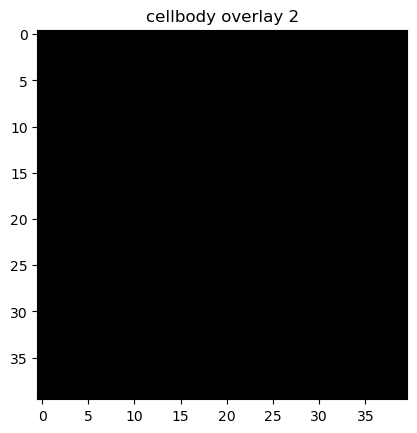

working on file3 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.0        41.0      507.222222


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


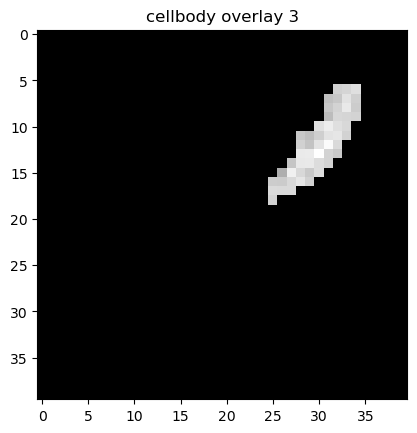

working on file3 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   37.571429   84.714286      370.357143


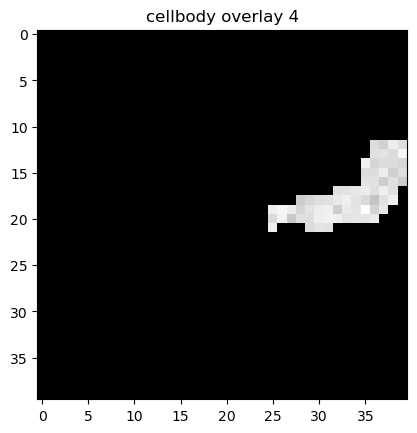

working on file3 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        31.0        69.0           297.0


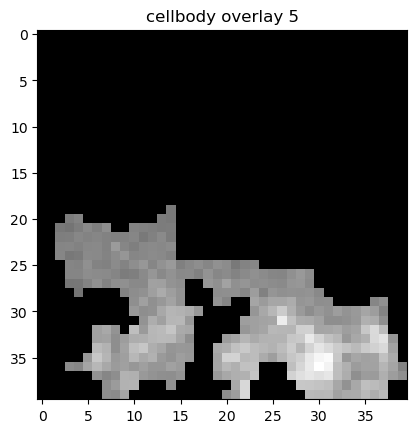

working on file3 and monos2,1
DEAD WORM ALERT 6 

working on file3 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0        48.0        90.0      454.222222


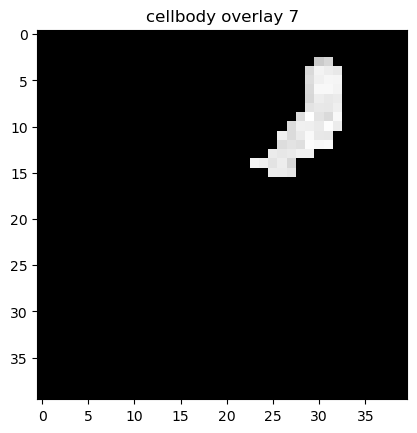

working on file3 and monos2,3
working on file3 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0      96.875     107.125          413.75


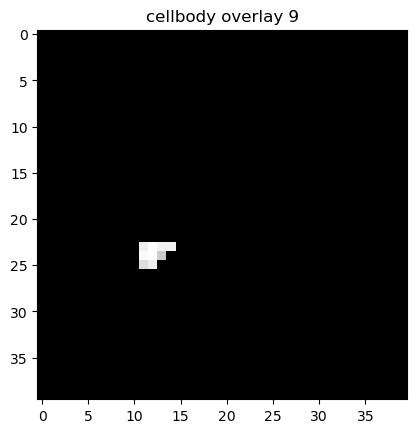

working on file3 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0      61.125     104.125         573.625


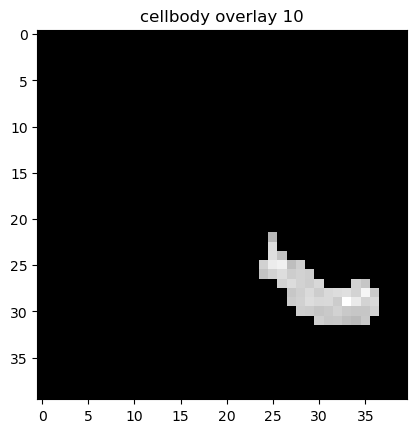

working on file3 and monos3,1
DEAD WORM ALERT 11 

working on file3 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0       104.0       54.25           414.0


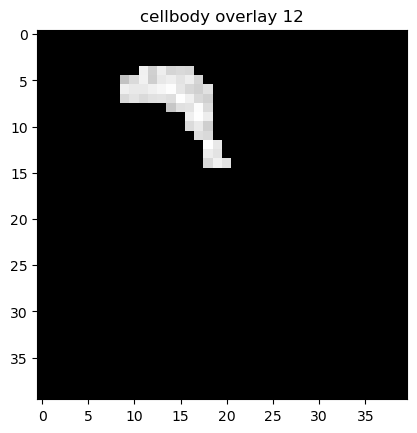

working on file3 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0      68.375      110.75         458.875


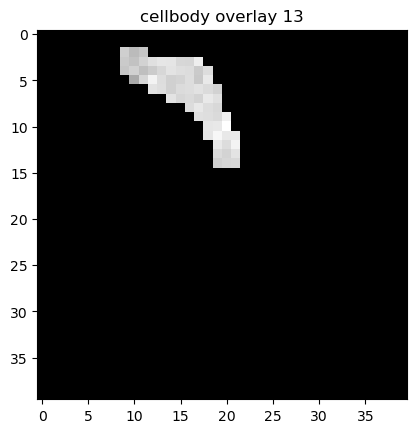

working on file3 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0       108.2        97.5           653.4


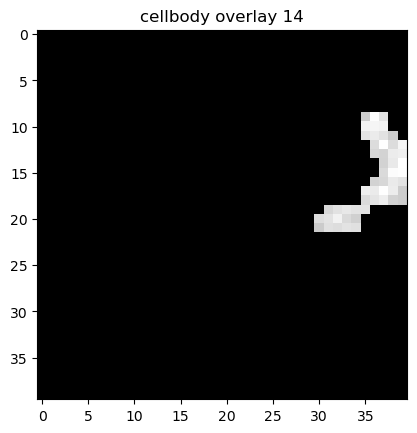

working on file3 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0        39.0        96.2           433.3


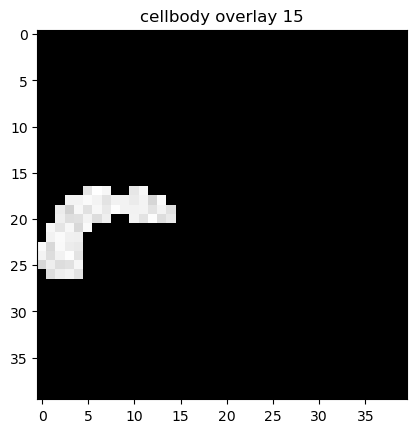

working on file3 and monos4,1
DEAD WORM ALERT 16 

working on file3 and monos4,2
working on file3 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0        39.5   72.285714      378.357143


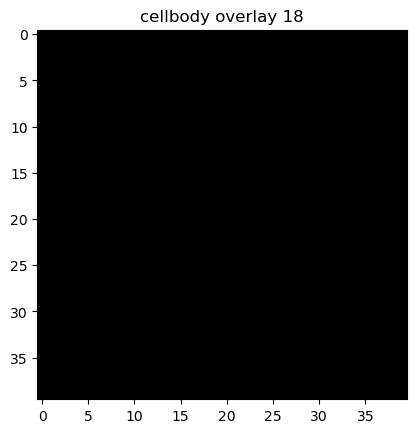

working on file3 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0   89.818182   87.727273           402.0


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


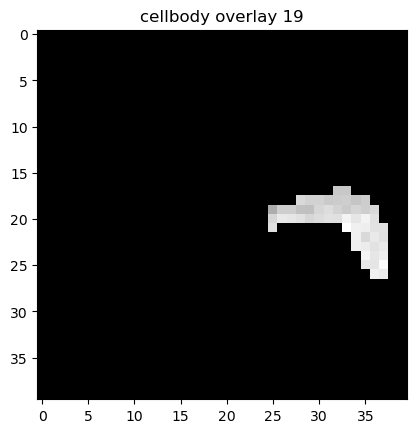

working on file3 and monos4,5
working on file3 and monos5,1
DEAD WORM ALERT 21 

working on file3 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0       64.25  122.666667           500.5


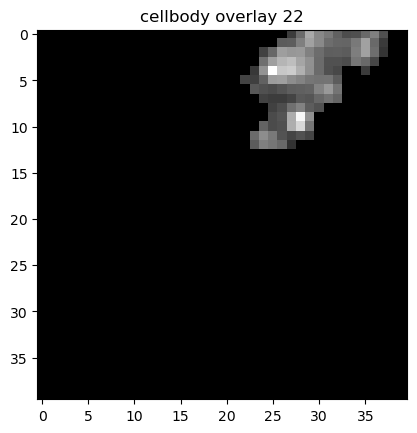

working on file3 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0   30.384615   79.384615      476.153846


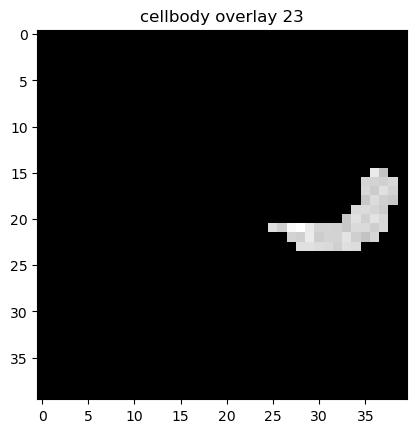

working on file3 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.857143   80.714286      543.428571


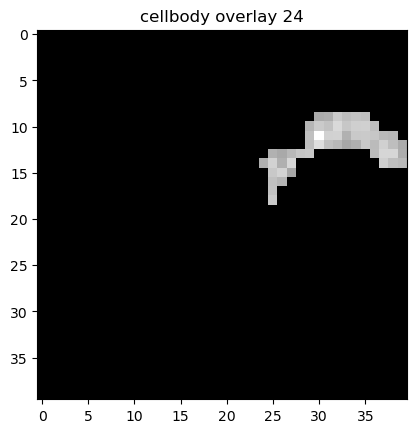

working on file3 and monos5,5
Centroids: [(nan, nan), [88, 77], [44, 41], [37, 84], [31, 69], (nan, nan), [48, 90], (nan, nan), [96, 107], [61, 104], (nan, nan), [104, 54], [68, 110], [108, 97], [39, 96], (nan, nan), (nan, nan), [39, 72], [89, 87], (nan, nan), (nan, nan), [64, 122], [30, 79], [44, 80], (nan, nan)]
X Positions: [nan, 88, 44, 37, 31, nan, 48, nan, 96, 61, nan, 104, 68, 108, 39, nan, nan, 39, 89, nan, nan, 64, 30, 44, nan]
Y Positions: [nan, 77, 41, 84, 69, nan, 90, nan, 107, 104, nan, 54, 110, 97, 96, nan, nan, 72, 87, nan, nan, 122, 79, 80, nan]
mKate Intensities: [nan, 429.9, 507.2, 370.4, 297.0, nan, 454.2, nan, 413.8, 573.6, nan, 414.0, 458.9, 653.4, 433.3, nan, nan, 378.4, 402.0, nan, nan, 500.5, 476.2, 543.4, nan]
gCamp Intensities: [nan, nan, 189.5, 170.8, 224.2, nan, 181.2, nan, 184.4, 179.5, nan, 193.2, 179.0, 191.0, 172.0, nan, nan, nan, 167.3, nan, nan, 528.9, 178.9, 187.9, nan]
Speed: [nan, 142.67928908149213, 183.92332515828434, 140.94485850118832, 52.266255

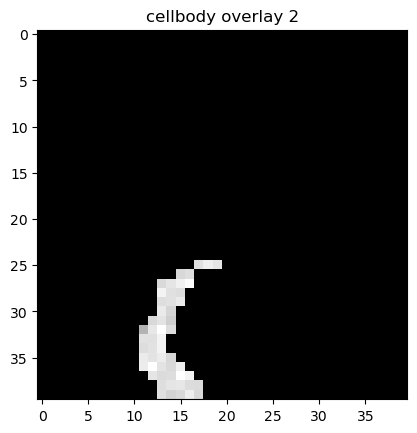

working on file4 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.0        40.8           496.7


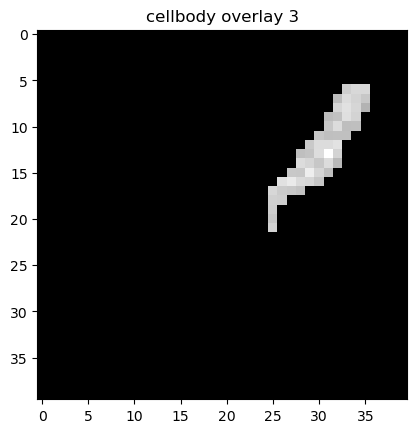

working on file4 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   36.666667   93.111111      487.888889


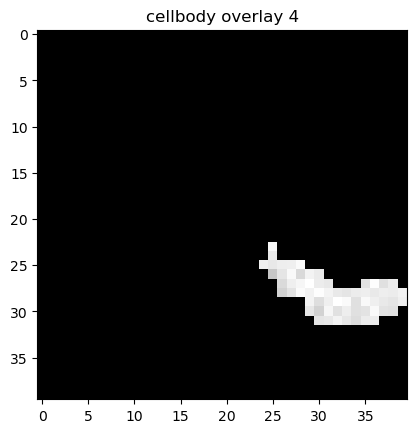

working on file4 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        30.0        67.0           278.0
1        31.0        69.0           279.0


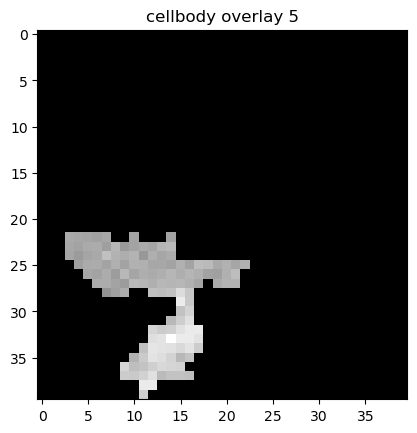

working on file4 and monos2,1
DEAD WORM ALERT 6 

working on file4 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0   45.636364   85.545455      374.181818


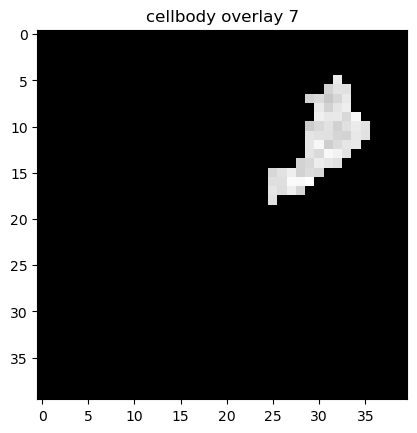

working on file4 and monos2,3
working on file4 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0   96.333333  107.888889      398.777778


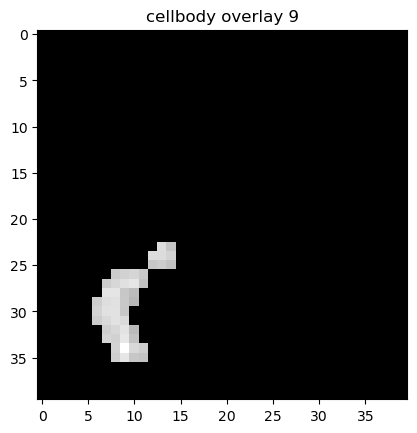

working on file4 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0   60.777778  104.555556      522.222222


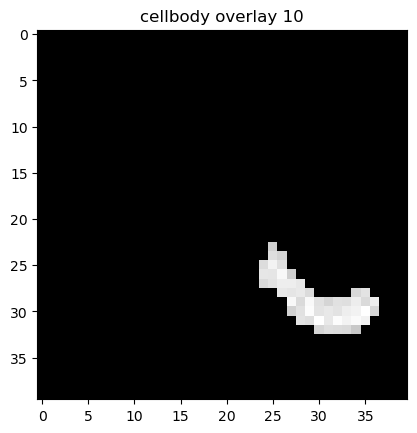

working on file4 and monos3,1
DEAD WORM ALERT 11 

working on file4 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0     103.875      53.875          410.25


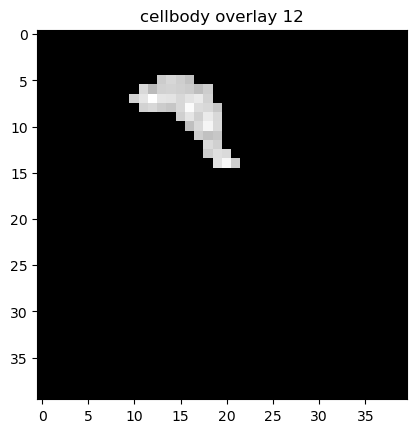

working on file4 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0        52.5        94.5           463.5


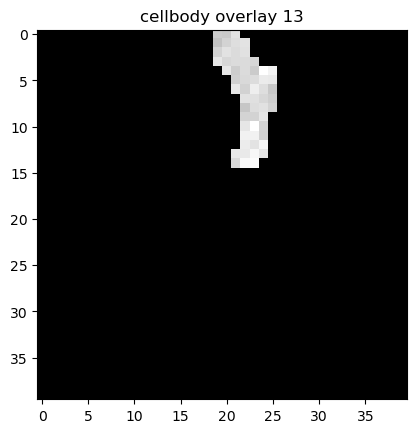

working on file4 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0  108.090909   97.636364      629.636364


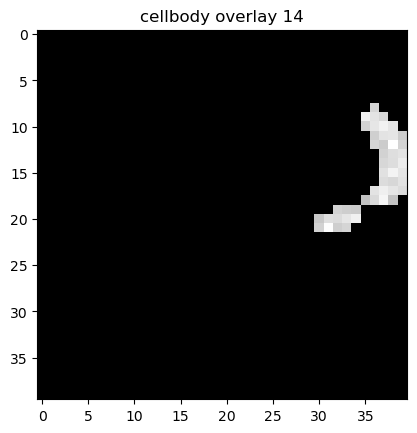

working on file4 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0   44.333333  117.888889           407.0


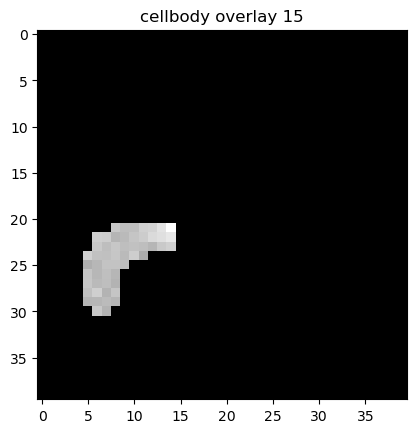

working on file4 and monos4,1
DEAD WORM ALERT 16 

working on file4 and monos4,2
working on file4 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0   39.357143   72.214286           380.0


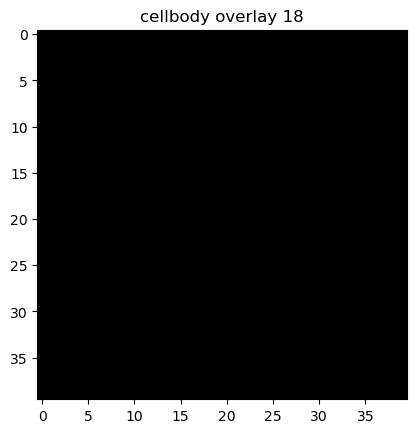

working on file4 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0   79.384615   94.615385      390.153846


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


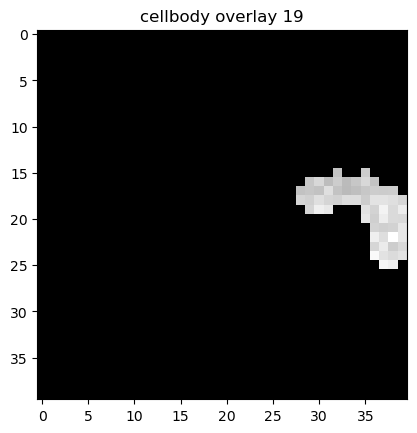

working on file4 and monos4,5
working on file4 and monos5,1
DEAD WORM ALERT 21 

working on file4 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0   63.384615  122.615385      484.461538


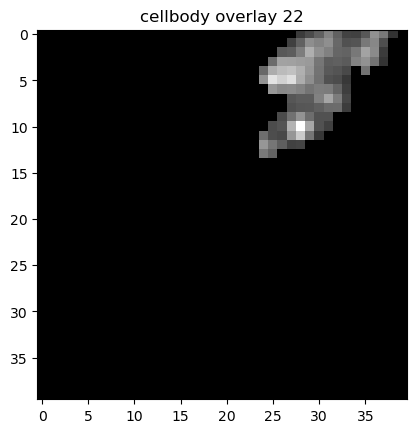

working on file4 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0        43.5        95.5      453.142857


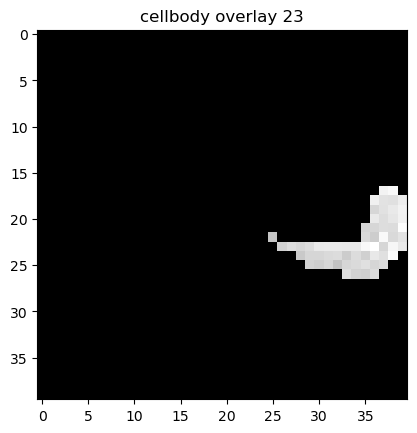

working on file4 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.714286        80.5      544.928571


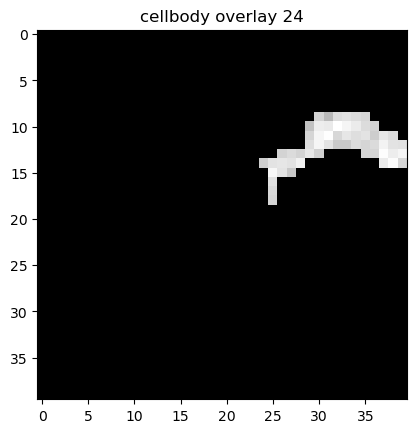

working on file4 and monos5,5
Centroids: [(nan, nan), [83, 70], [44, 40], [36, 93], [30, 67], (nan, nan), [45, 85], (nan, nan), [96, 107], [60, 104], (nan, nan), [103, 53], [52, 94], [108, 97], [44, 117], (nan, nan), (nan, nan), [39, 72], [79, 94], (nan, nan), (nan, nan), [63, 122], [43, 95], [44, 80], (nan, nan)]
X Positions: [nan, 83, 44, 36, 30, nan, 45, nan, 96, 60, nan, 103, 52, 108, 44, nan, nan, 39, 79, nan, nan, 63, 43, 44, nan]
Y Positions: [nan, 70, 40, 93, 67, nan, 85, nan, 107, 104, nan, 53, 94, 97, 117, nan, nan, 72, 94, nan, nan, 122, 95, 80, nan]
mKate Intensities: [nan, 563.7, 496.7, 487.9, 278.0, nan, 374.2, nan, 398.8, 522.2, nan, 410.2, 463.5, 629.6, 407.0, nan, nan, 380.0, 390.2, nan, nan, 484.5, 453.1, 544.9, nan]
gCamp Intensities: [nan, 179.1, 191.0, 171.2, 206.3, nan, 179.6, nan, 187.8, 182.5, nan, 195.8, 181.6, 193.2, 174.4, nan, nan, nan, 168.3, nan, nan, 537.8, 169.3, 190.6, nan]
Speed: [nan, 130.25447156946282, 159.18367565752462, 173.4079271599773, 86.32590

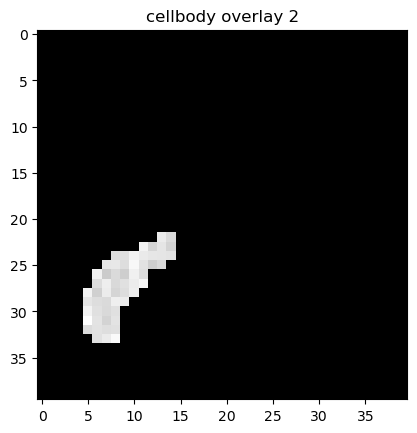

working on file5 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.0        40.8           495.8


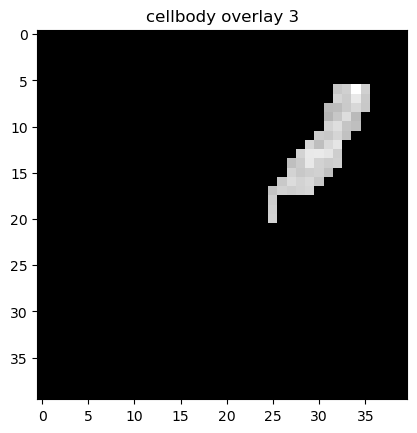

working on file5 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0       40.25   98.416667      400.916667


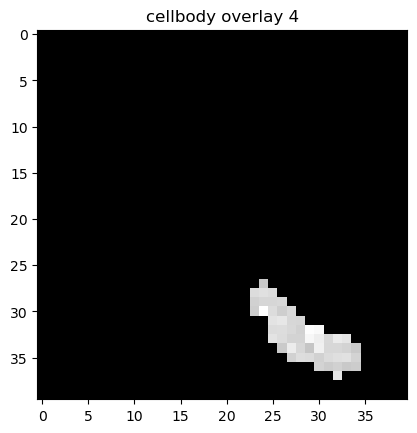

working on file5 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        30.0        67.0           280.0


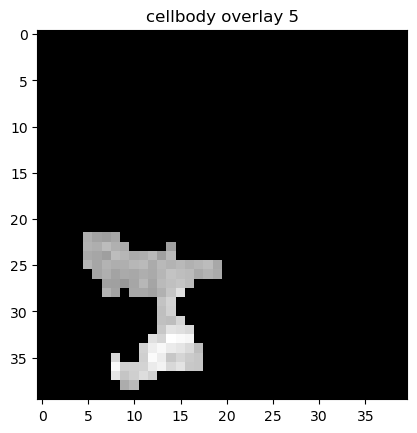

working on file5 and monos2,1
DEAD WORM ALERT 6 

working on file5 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0        39.2        99.5           443.9


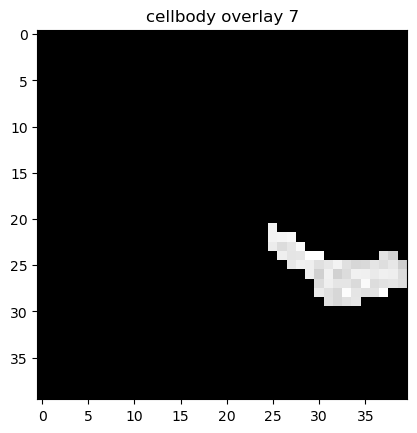

working on file5 and monos2,3
working on file5 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0        96.0       108.0      388.555556


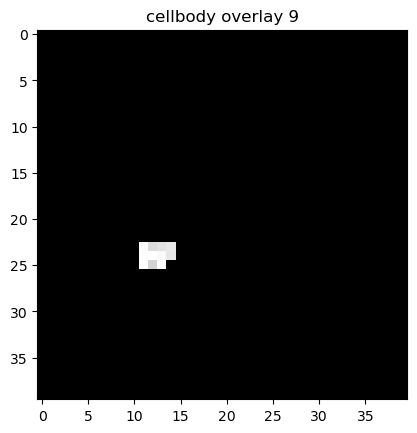

working on file5 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0        61.2       104.5           504.7


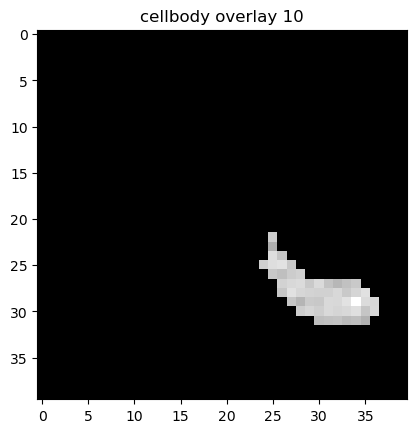

working on file5 and monos3,1
DEAD WORM ALERT 11 

working on file5 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0       104.0        54.0      425.714286


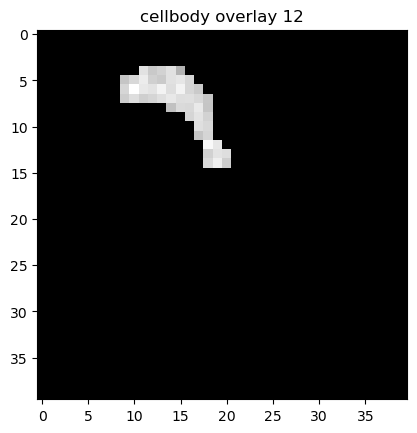

working on file5 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0      43.125      86.875          398.75


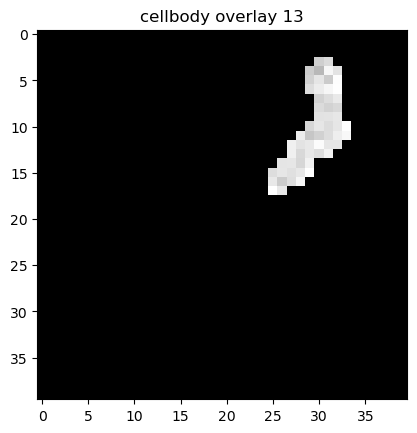

working on file5 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0  108.090909   97.636364      630.181818


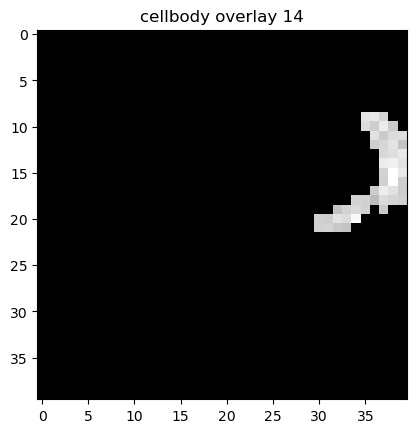

working on file5 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0   34.333333  118.888889      426.444444


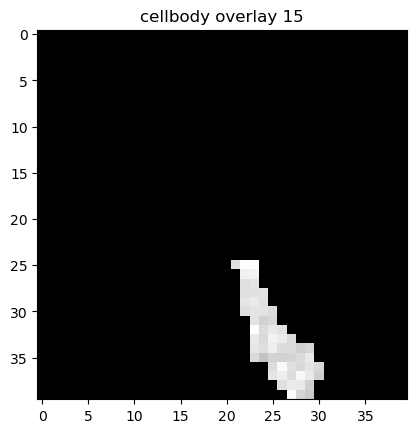

working on file5 and monos4,1
DEAD WORM ALERT 16 

working on file5 and monos4,2
working on file5 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0   39.230769   72.230769      392.538462


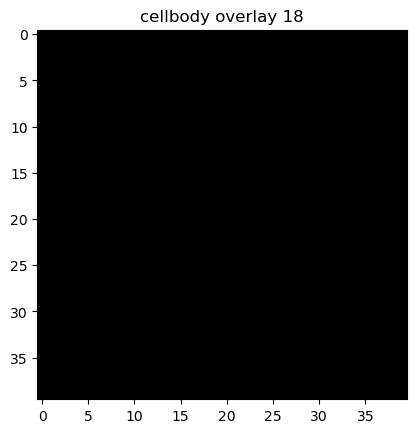

working on file5 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0        69.5       109.0           358.5


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


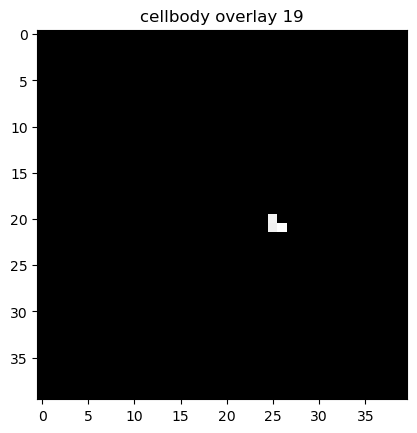

working on file5 and monos4,5
working on file5 and monos5,1
DEAD WORM ALERT 21 

working on file5 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0        62.5       122.5           475.5


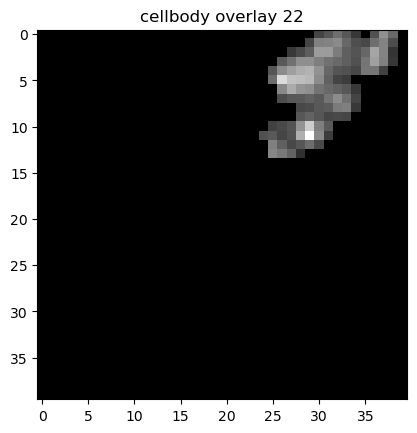

working on file5 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0   58.733333  104.933333      466.333333


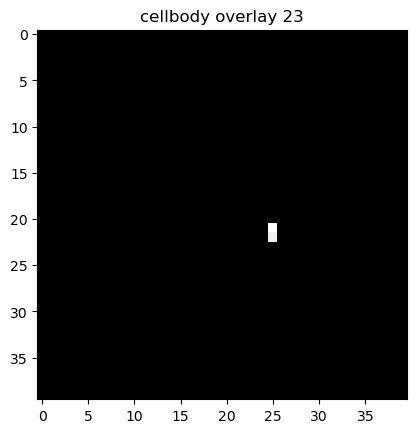

working on file5 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.733333   80.666667      527.466667


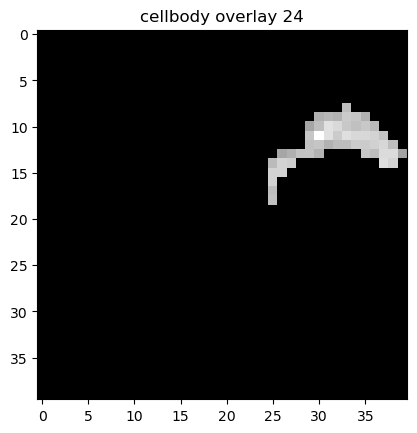

working on file5 and monos5,5
Centroids: [(nan, nan), [103, 77], [44, 40], [40, 98], [30, 67], (nan, nan), [39, 99], (nan, nan), [96, 108], [61, 104], (nan, nan), [104, 54], [43, 86], [108, 97], [34, 118], (nan, nan), (nan, nan), [39, 72], [69, 109], (nan, nan), (nan, nan), [62, 122], [58, 104], [44, 80], (nan, nan)]
X Positions: [nan, 103, 44, 40, 30, nan, 39, nan, 96, 61, nan, 104, 43, 108, 34, nan, nan, 39, 69, nan, nan, 62, 58, 44, nan]
Y Positions: [nan, 77, 40, 98, 67, nan, 99, nan, 108, 104, nan, 54, 86, 97, 118, nan, nan, 72, 109, nan, nan, 122, 104, 80, nan]
mKate Intensities: [nan, 499.1, 495.8, 400.9, 280.0, nan, 443.9, nan, 388.6, 504.7, nan, 425.7, 398.8, 630.2, 426.4, nan, nan, 392.5, 358.5, nan, nan, 475.5, 466.3, 527.5, nan]
gCamp Intensities: [nan, 177.8, 191.2, 173.3, 207.4, nan, 180.4, nan, 188.5, 183.3, nan, 193.7, 186.2, 189.9, 172.4, nan, nan, nan, 171.7, nan, nan, 537.4, 168.5, 191.1, nan]
Speed: [nan, 191.12339325577076, 225.30560877173033, 188.0873051409903, 10

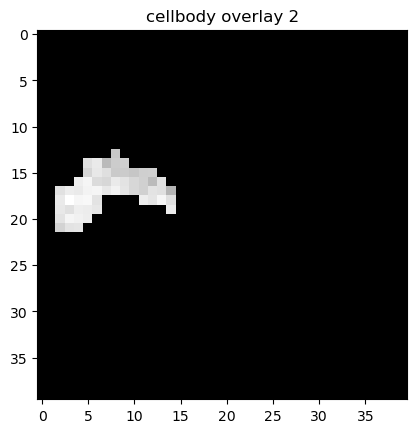

working on file6 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.0        40.8           508.6


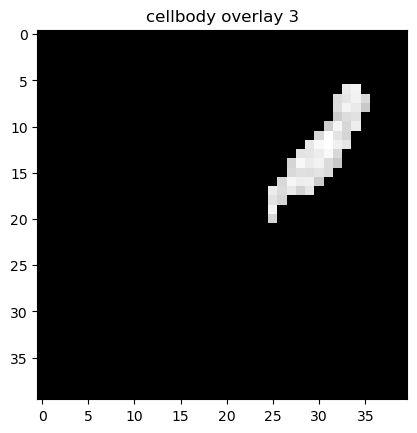

working on file6 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   48.888889   99.666667      468.222222


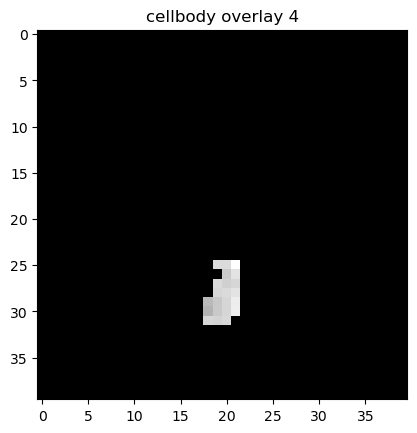

working on file6 and monos1,5
working on file6 and monos2,1
DEAD WORM ALERT 6 

working on file6 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0        46.5     105.125         528.875


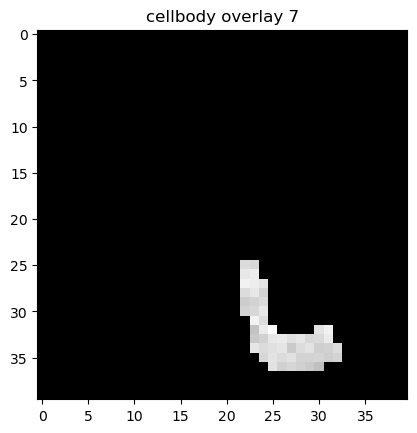

working on file6 and monos2,3
working on file6 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0        96.0  108.285714      426.857143


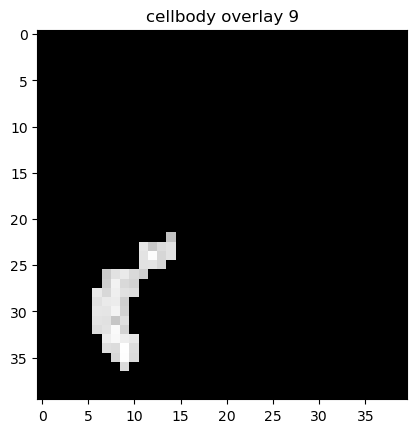

working on file6 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0       60.75     104.375           565.5


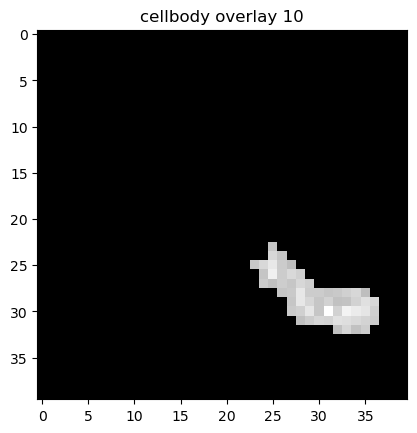

working on file6 and monos3,1
DEAD WORM ALERT 11 

working on file6 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0       104.0       54.25         408.375


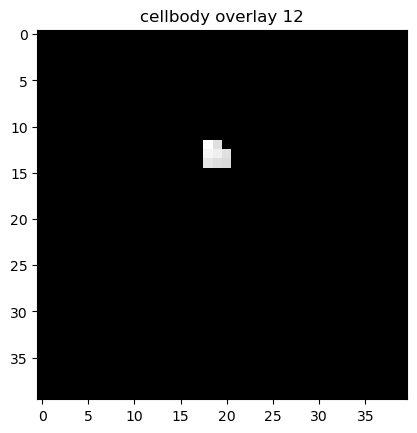

working on file6 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0        46.5        81.5           425.0


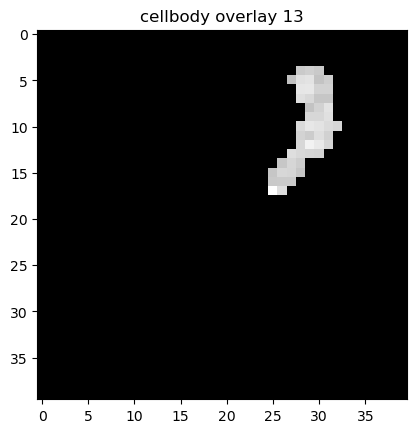

working on file6 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0       108.2        98.5           656.8


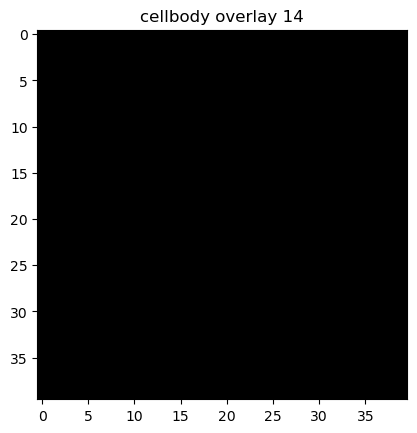

working on file6 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0        40.5       112.0          447.25


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


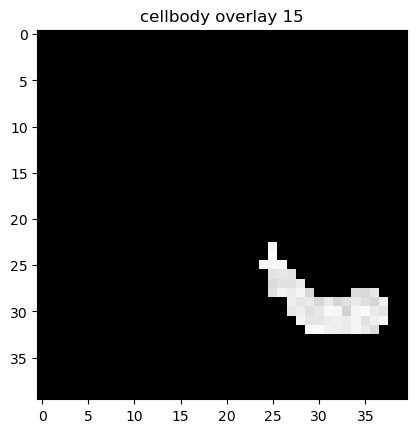

working on file6 and monos4,1
DEAD WORM ALERT 16 

working on file6 and monos4,2
working on file6 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0   39.166667   72.083333      396.583333


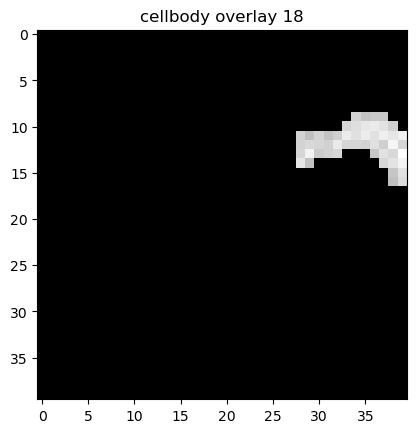

working on file6 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0        84.0       121.8           399.3


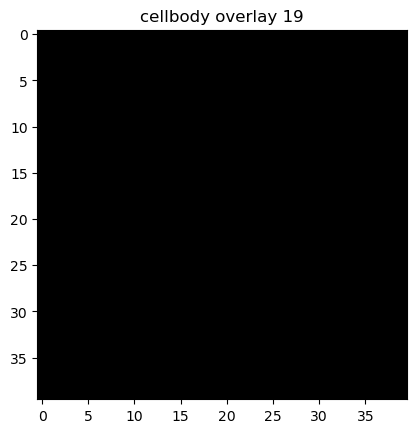

/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


working on file6 and monos4,5
working on file6 and monos5,1
DEAD WORM ALERT 21 

working on file6 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0   62.384615  122.615385      477.307692


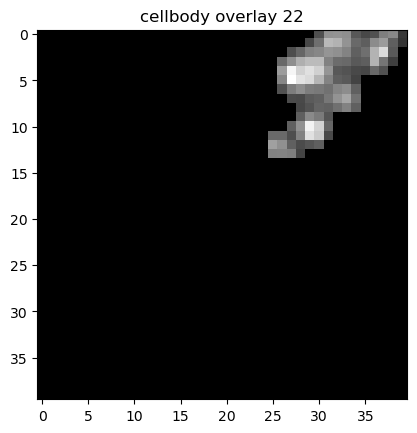

working on file6 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0        67.2       113.5           612.9


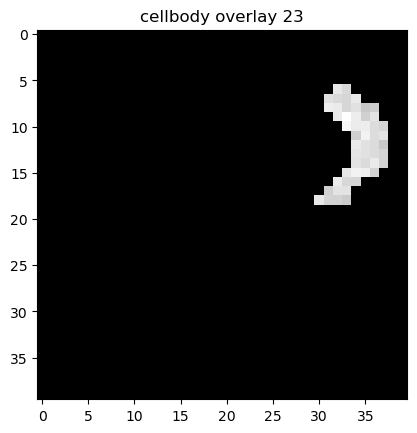

working on file6 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.714286        80.5           544.0


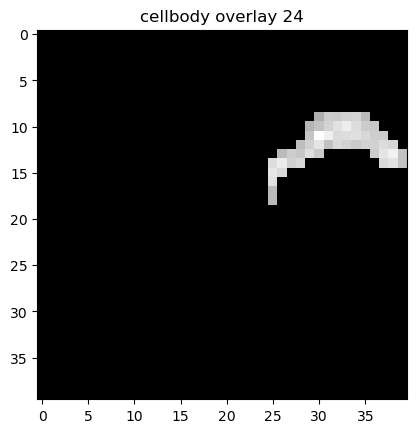

working on file6 and monos5,5
Centroids: [(nan, nan), [104, 84], [44, 40], [48, 99], (nan, nan), (nan, nan), [46, 105], (nan, nan), [96, 108], [60, 104], (nan, nan), [104, 54], [46, 81], [108, 98], [40, 112], (nan, nan), (nan, nan), [39, 72], [84, 121], (nan, nan), (nan, nan), [62, 122], [67, 113], [44, 80], (nan, nan)]
X Positions: [nan, 104, 44, 48, nan, nan, 46, nan, 96, 60, nan, 104, 46, 108, 40, nan, nan, 39, 84, nan, nan, 62, 67, 44, nan]
Y Positions: [nan, 84, 40, 99, nan, nan, 105, nan, 108, 104, nan, 54, 81, 98, 112, nan, nan, 72, 121, nan, nan, 122, 113, 80, nan]
mKate Intensities: [nan, 532.6, 508.6, 468.2, nan, nan, 528.9, nan, 426.9, 565.5, nan, 408.4, 425.0, 656.8, 447.2, nan, nan, 396.6, 399.3, nan, nan, 477.3, 612.9, 544.0, nan]
gCamp Intensities: [nan, 172.0, 189.6, 159.1, nan, nan, 182.5, nan, 189.5, 181.0, nan, 194.5, 190.7, nan, 170.8, nan, nan, 196.1, nan, nan, nan, 538.9, 179.0, 192.3, nan]
Speed: [nan, 194.54288177324813, 240.71279443652347, 191.31496826667797, n

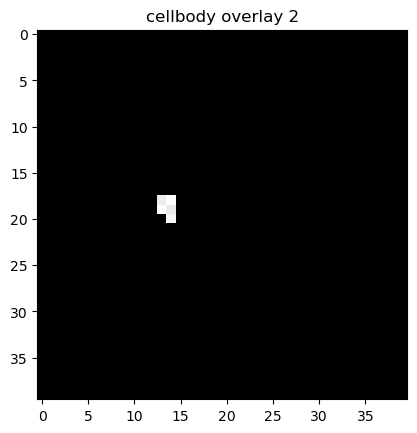

working on file7 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0   44.363636   40.545455      494.181818


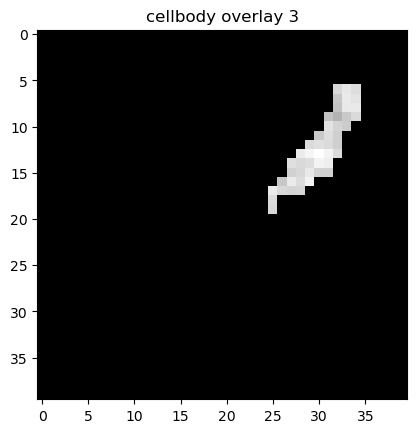

working on file7 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   66.272727   97.181818      465.636364


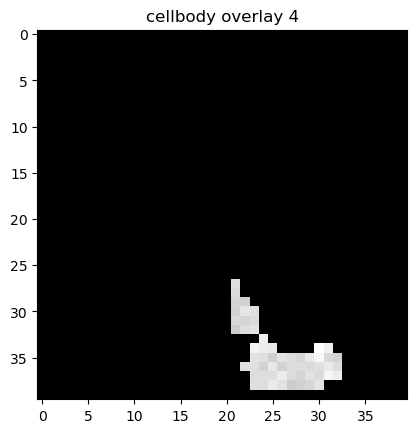

working on file7 and monos1,5
working on file7 and monos2,1
DEAD WORM ALERT 6 

working on file7 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0   65.555556  105.666667      457.111111


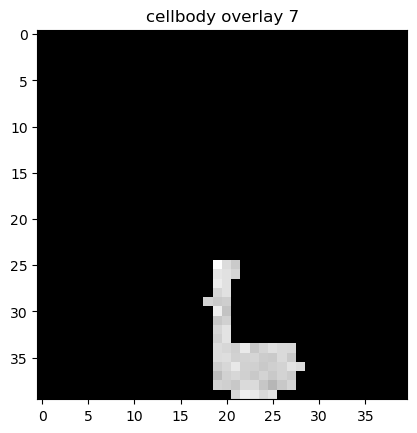

working on file7 and monos2,3
working on file7 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0   95.285714       109.0      414.428571


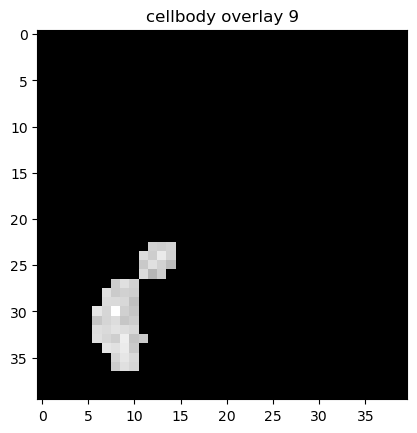

working on file7 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0        61.0  104.285714      589.428571


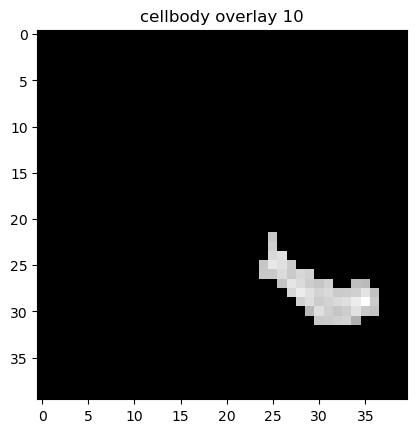

working on file7 and monos3,1
DEAD WORM ALERT 11 

working on file7 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0     103.875      53.875          408.25


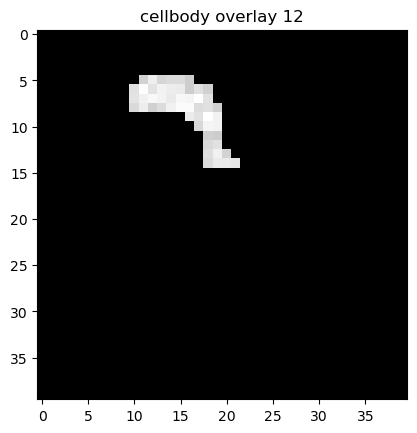

working on file7 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0   49.142857   83.285714      432.428571


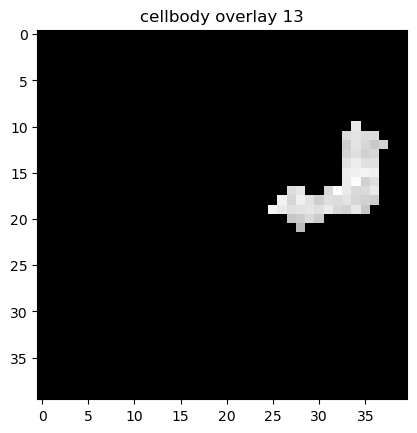

working on file7 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0       108.2        98.5           656.0


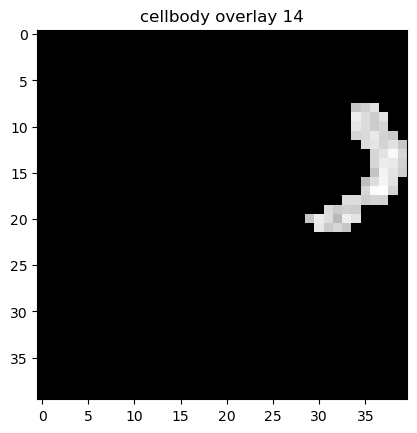

working on file7 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0   43.181818   93.909091      400.727273


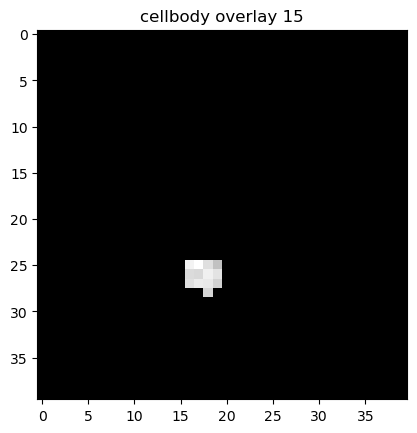

working on file7 and monos4,1
DEAD WORM ALERT 16 

working on file7 and monos4,2
working on file7 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0        39.0        72.5      399.666667


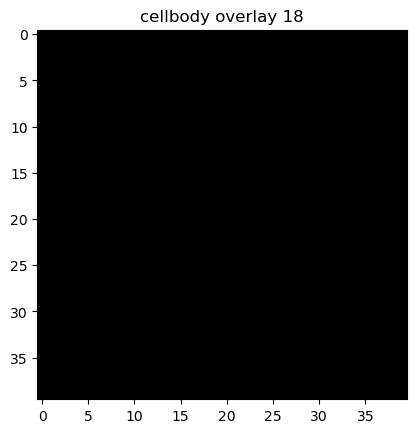

working on file7 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0        95.5       104.5      427.083333


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


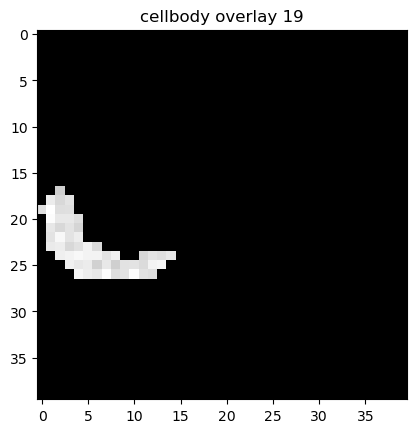

working on file7 and monos4,5
working on file7 and monos5,1
DEAD WORM ALERT 21 

working on file7 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0   62.615385  122.384615      498.230769


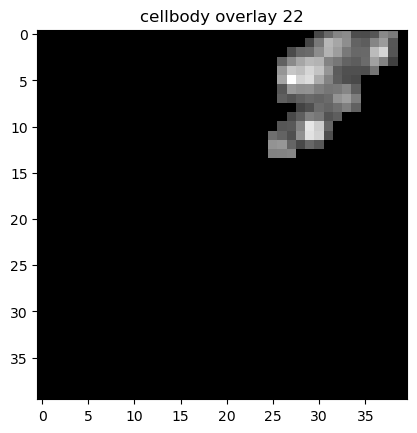

working on file7 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0        71.0       120.5      536.333333


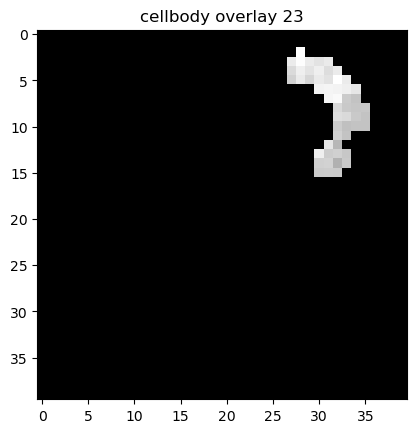

working on file7 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.714286        80.5      544.071429


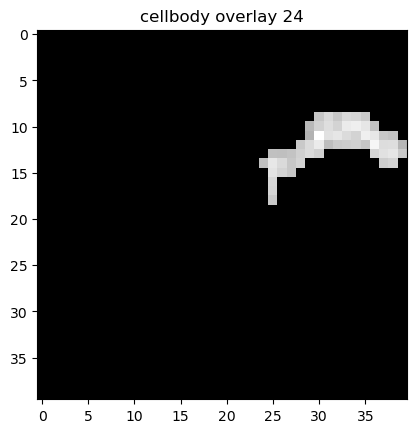

working on file7 and monos5,5
Centroids: [(nan, nan), [100, 87], [44, 40], [66, 97], (nan, nan), (nan, nan), [65, 105], (nan, nan), [95, 109], [61, 104], (nan, nan), [103, 53], [49, 83], [108, 98], [43, 93], (nan, nan), (nan, nan), [39, 72], [95, 104], (nan, nan), (nan, nan), [62, 122], [71, 120], [44, 80], (nan, nan)]
X Positions: [nan, 100, 44, 66, nan, nan, 65, nan, 95, 61, nan, 103, 49, 108, 43, nan, nan, 39, 95, nan, nan, 62, 71, 44, nan]
Y Positions: [nan, 87, 40, 97, nan, nan, 105, nan, 109, 104, nan, 53, 83, 98, 93, nan, nan, 72, 104, nan, nan, 122, 120, 80, nan]
mKate Intensities: [nan, 501.8, 494.2, 465.6, nan, nan, 457.1, nan, 414.4, 589.4, nan, 408.2, 432.4, 656.0, 400.7, nan, nan, 399.7, 427.1, nan, nan, 498.2, 536.3, 544.1, nan]
gCamp Intensities: [nan, 174.5, 193.6, 174.4, nan, nan, 181.9, nan, 187.8, 180.9, nan, 190.4, 186.1, 190.5, 158.8, nan, nan, nan, 179.7, nan, nan, 545.8, 171.1, 188.3, nan]
Speed: [nan, 182.58111387106828, 236.5238767414402, 197.66516024914455, na

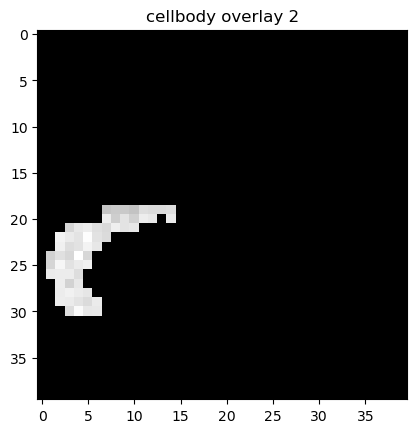

working on file8 and monos1,3
Subsection 3:
   centroid-0  centroid-1  intensity_mean
0        44.5        40.5      472.333333


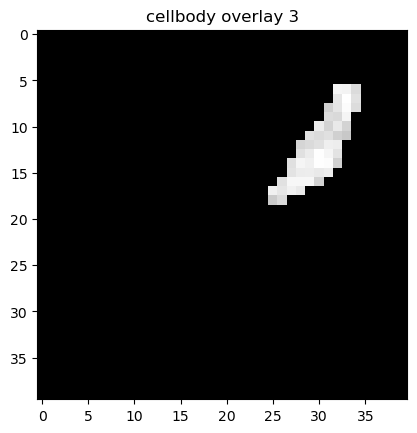

working on file8 and monos1,4
Subsection 4:
   centroid-0  centroid-1  intensity_mean
0   68.636364  101.363636           358.0


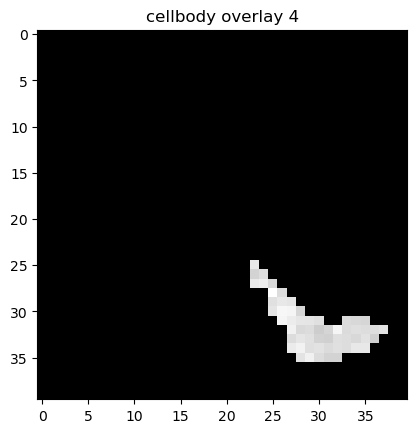

working on file8 and monos1,5
Subsection 5:
   centroid-0  centroid-1  intensity_mean
0        30.0        67.0           289.0
1        31.0        69.0           277.0


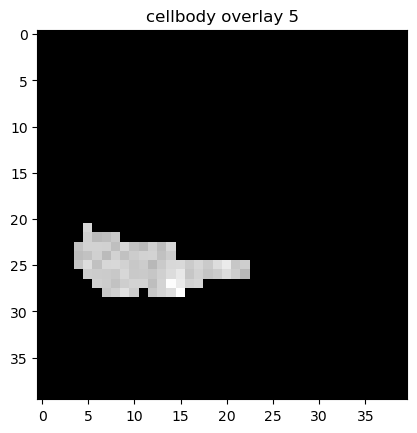

working on file8 and monos2,1
DEAD WORM ALERT 6 

working on file8 and monos2,2
Subsection 7:
   centroid-0  centroid-1  intensity_mean
0        82.5       105.8           486.6


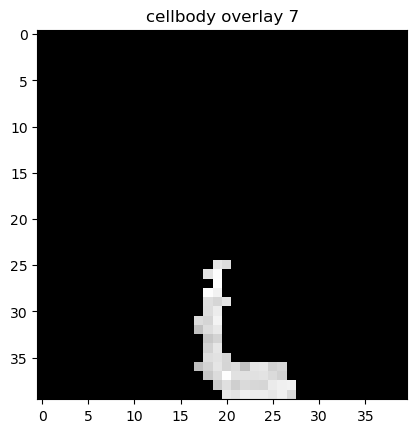

working on file8 and monos2,3
working on file8 and monos2,4
Subsection 9:
   centroid-0  centroid-1  intensity_mean
0      92.875     111.125          414.25


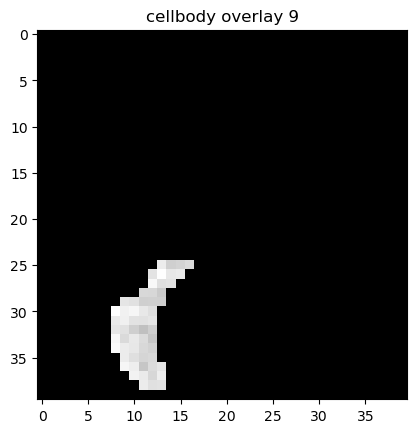

working on file8 and monos2,5
Subsection 10:
   centroid-0  centroid-1  intensity_mean
0      61.125     104.125          570.25


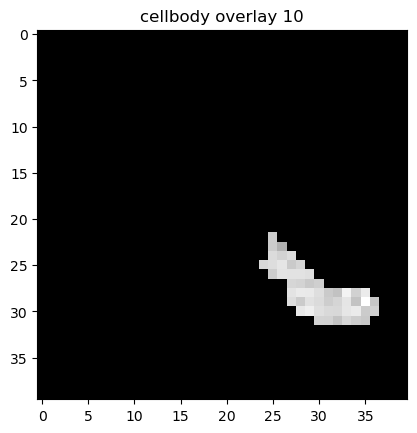

working on file8 and monos3,1
DEAD WORM ALERT 11 

working on file8 and monos3,2
Subsection 12:
   centroid-0  centroid-1  intensity_mean
0  103.888889   54.111111      394.333333


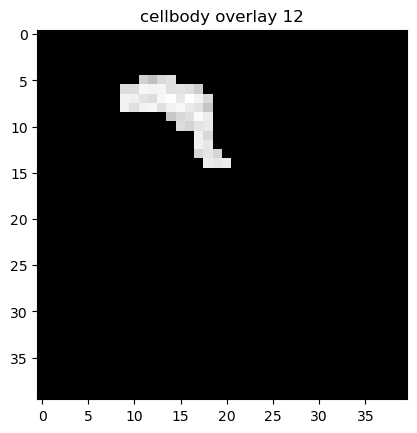

working on file8 and monos3,3
Subsection 13:
   centroid-0  centroid-1  intensity_mean
0   49.333333   79.111111      386.777778


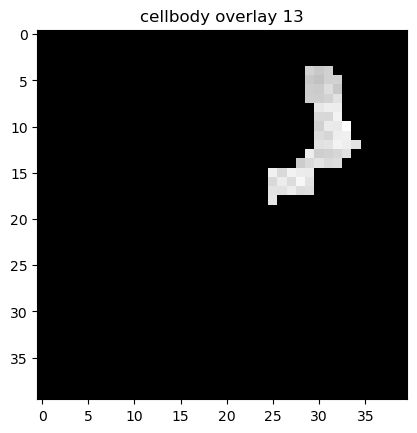

working on file8 and monos3,4
Subsection 14:
   centroid-0  centroid-1  intensity_mean
0  108.083333   98.166667      590.666667


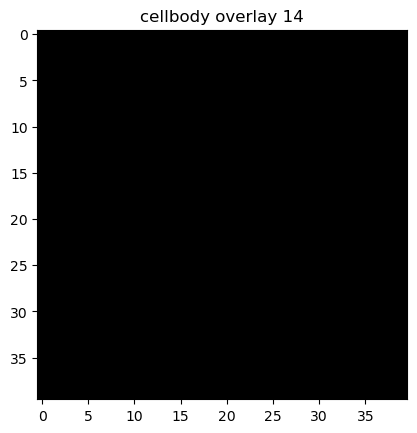

working on file8 and monos3,5
Subsection 15:
   centroid-0  centroid-1  intensity_mean
0        33.8        76.9           408.6


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


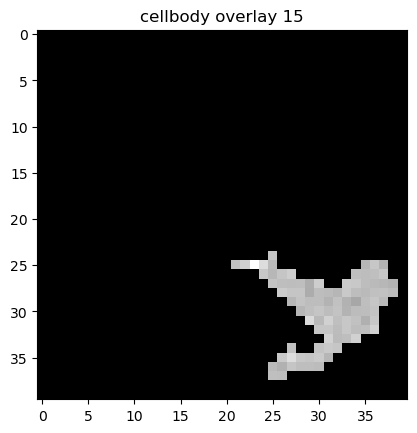

working on file8 and monos4,1
DEAD WORM ALERT 16 

working on file8 and monos4,2
working on file8 and monos4,3
Subsection 18:
   centroid-0  centroid-1  intensity_mean
0        39.0        72.5      402.583333


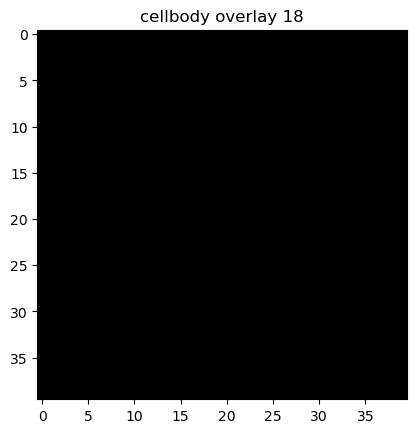

working on file8 and monos4,4
Subsection 19:
   centroid-0  centroid-1  intensity_mean
0   99.818182  100.545455      448.727273


/var/folders/7q/lxx5yk957r1701z95mplwsc00000gn/T/ipykernel_32446/2141799475.py:199: RuntimeWarning: Mean of empty slice.
  gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))
/Users/dklee/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


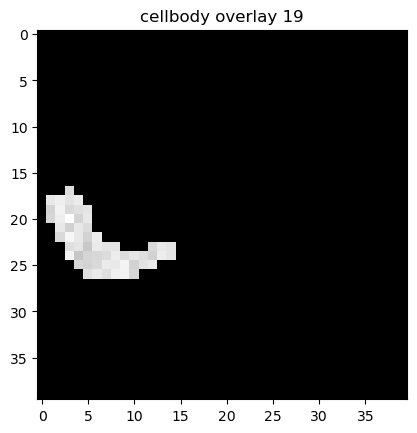

working on file8 and monos4,5
working on file8 and monos5,1
DEAD WORM ALERT 21 

working on file8 and monos5,2
Subsection 22:
   centroid-0  centroid-1  intensity_mean
0   62.090909  122.636364      532.181818


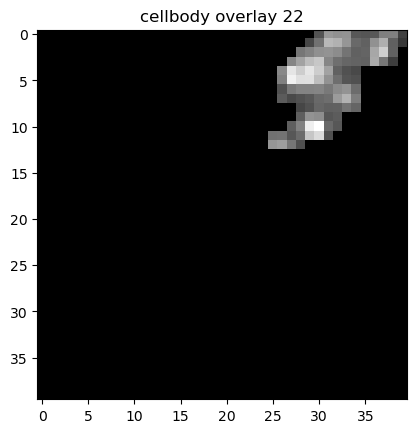

working on file8 and monos5,3
Subsection 23:
   centroid-0  centroid-1  intensity_mean
0   72.636364  139.090909      534.818182


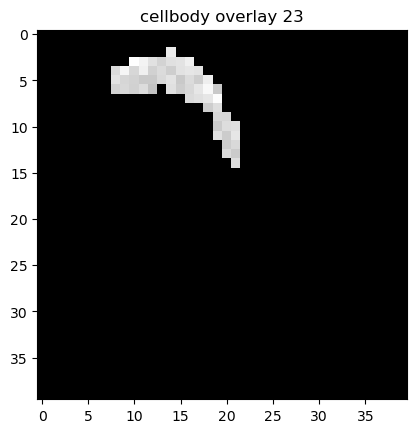

working on file8 and monos5,4
Subsection 24:
   centroid-0  centroid-1  intensity_mean
0   44.733333   80.666667      530.533333


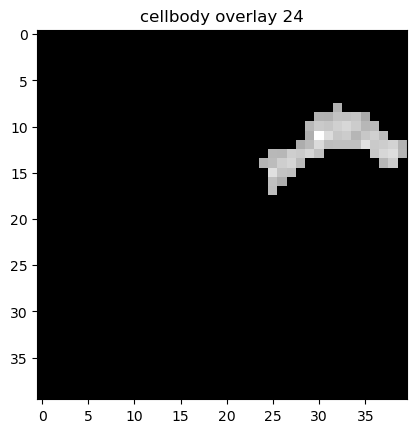

working on file8 and monos5,5
Centroids: [(nan, nan), [91, 79], [44, 40], [68, 101], [30, 67], (nan, nan), [82, 105], (nan, nan), [92, 111], [61, 104], (nan, nan), [103, 54], [49, 79], [108, 98], [33, 76], (nan, nan), (nan, nan), [39, 72], [99, 100], (nan, nan), (nan, nan), [62, 122], [72, 139], [44, 80], (nan, nan)]
X Positions: [nan, 91, 44, 68, 30, nan, 82, nan, 92, 61, nan, 103, 49, 108, 33, nan, nan, 39, 99, nan, nan, 62, 72, 44, nan]
Y Positions: [nan, 79, 40, 101, 67, nan, 105, nan, 111, 104, nan, 54, 79, 98, 76, nan, nan, 72, 100, nan, nan, 122, 139, 80, nan]
mKate Intensities: [nan, 508.4, 472.3, 358.0, 289.0, nan, 486.6, nan, 414.2, 570.2, nan, 394.3, 386.8, 590.7, 408.6, nan, nan, 402.6, 448.7, nan, nan, 532.2, 534.8, 530.5, nan]
gCamp Intensities: [nan, 176.3, 190.3, 152.5, 190.2, nan, 182.6, nan, 185.3, 181.7, nan, 191.8, 181.4, nan, 175.0, nan, nan, nan, 180.2, nan, nan, 552.4, 179.4, 190.7, nan]
Speed: [nan, 152.0888131270673, 197.58571815594362, 212.0722337197399, 164.9

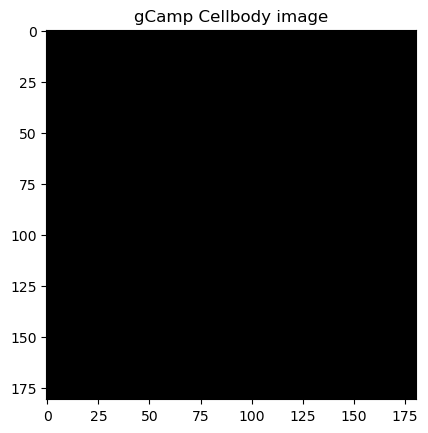

In [73]:
#final pipeline 

#Function Declarations:

#appending nan to arrays
def nan_append(area, centroids, x_pos, y_pos, mKate_intensity, gCamp_intensity, speeds):
    area.append(np.nan)
    centroids.append((np.nan, np.nan))
    x_pos.append(np.nan)
    y_pos.append(np.nan)
    mKate_intensity.append(np.nan)
    gCamp_intensity.append(np.nan)
    speeds.append(np.nan)
    
#speed calculation function
def calculate_speed(prev_x, prev_y, curr_x, curr_y, time):
    deltax = curr_x - prev_x
    deltay = curr_y - prev_y
    speed = 1.6176 * np.sqrt(deltax**2 + deltay**2) / time
    return speed

#remove blob removes extra blobs aside from the desired neurite 
def removeBlobs(original_image, labeled_image):
    objects = skimage.measure.regionprops(labeled_image)
    object_areas = [obj["area"] for obj in objects]
    object_max = max(object_areas)        
    small_objects =[obj for obj in objects if obj.area != object_max]
    for i in small_objects:
        original_image[i.bbox[0]:i.bbox[2], i.bbox[1]:i.bbox[3]] = 0
        
#sorting function helper method    
def sorting_char(x):
    arr = x.split("_")
    return arr[2]


#Main Function:
def backend_pipeline(total_num_worms, dead_worms, time):
    
    #Initializing files and input variables
    if not math.sqrt(total_num_worms).is_integer():
        return "invalid number of total worms"
    num_worms = int(math.sqrt(total_num_worms))
    if time <= 0:
        return "invalid time"
    if not isinstance(dead_worms, list):
        return "dead_worms must be a list"
    files_mono1 = [file for file in os.listdir('./data') if file.endswith('Mono1.tif')] 
    files_mono = [file for file in os.listdir('./data') if file.endswith('Mono.tif')]
    if not files_mono1 or not files_mono:
        raise FileNotFoundError('Necessary files not found')
    if len(files_mono1) != len(files_mono):
        return "Different number of mono1 and mono files"
    
    #sorting mono_1 and mono files to ensure the movie is played in the right order 
    mono1_files = sorted(files_mono1, key = sorting_char)
    mono_files = sorted(files_mono, key = sorting_char)
    prev_x_pos = None
    prev_y_pos = None
    
    
    #Running through all files 
    for i in range(len(mono1_files)):
        # Variable declaration
        x_pos = []
        y_pos = []
        centroids = []
        mKate_intensity = []
        gCamp_intensity = []
        speeds = []
        
        # Retreiving and copying image to prevent altering the original image
        mono1 = skimage.io.imread(os.getcwd() + "/data/" + mono1_files[i])
        mono = skimage.io.imread(os.getcwd() + "/data/" + mono_files[i])

        #update to num_worms 
        
        # Get Dimension, calculate padding and padded image
        mono1_height, mono1_width = mono1.shape
        mono1_pad_height = (5 - mono1_height % 5) % 5
        mono1_pad_width = (5 - mono1_width % 5) % 5
        mono1_padded_image = np.pad(mono1, ((0, mono1_pad_height), (0, mono1_pad_width)), mode='constant', constant_values=0)

        mono_height, mono_width = mono.shape
        mono_pad_height = (5 - mono_height % 5) % 5
        mono_pad_width = (5 - mono_width % 5) % 5
        mono_padded_image = np.pad(mono, ((0, mono_pad_height), (0, mono_pad_width)), mode='constant', constant_values=0)

        # Image split into subsections and running through each subsection
        # Vsplit for sub arrays 
        mono1_subsections = [np.hsplit(h, num_worms) for h in np.vsplit(mono1_padded_image, num_worms)]
        mono_subsections = [np.hsplit(h, num_worms) for h in np.vsplit(mono_padded_image, num_worms)]
            
        mono1_otsu_threshold = skimage.filters.threshold_otsu(mono1) - 30
        
        # Loop through the subsections 
        for k in range(num_worms):
            for p in range(num_worms):
                current_index = num_worms * k + p + 1
                print(f"working on file{i+1} and monos{k + 1},{p + 1}")

                if current_index in dead_worms:
                    print(f"DEAD WORM ALERT {current_index} \n")
                    nan_append(area, centroids, x_pos, y_pos, mKate_intensity, gCamp_intensity, speeds)
                    continue

                mKate_worm = mono1_subsections[k][p]
                gCamp_worm = mono_subsections[k][p]

                # Create a binary mask using Otsu's threshold
                cellBody_image = (mKate_worm > mono1_otsu_threshold).astype(int)
#               gCamp_image = gCamp_worm > mono1_otsu_threshold    
                

                labeled_mask = skimage.measure.label(cellBody_image)
                my_regions = skimage.measure.regionprops_table(labeled_mask, intensity_image=mKate_worm, properties=['centroid', 'intensity_mean'])
                regions_df = pd.DataFrame(my_regions)

                #Part 1 CODE: 
                if regions_df.empty:
                    nan_append(area, centroids, x_pos, y_pos, mKate_intensity, gCamp_intensity, speeds)
                    continue
                # Append numerical values instead of Series
                mKate_intensity.append(round(regions_df['intensity_mean'].values[0], 1))
                xpos = int(round(regions_df['centroid-0'].values[0], 1))
                ypos = int(round(regions_df['centroid-1'].values[0], 1))
                centroids.append([xpos, ypos])
                x_pos.append(xpos)
                y_pos.append(ypos)
                # Calculating speed
                if prev_x_pos is not None and prev_y_pos is not None:
                    speed = calculate_speed(prev_x_pos, prev_y_pos, xpos, ypos, time)
                    speeds.append(speed)
                else:
                    speeds.append(np.nan)
                # Save the current positions for the next iteration
                prev_x_pos = xpos
                prev_y_pos = ypos

#                 # Print the region properties DataFrame
#                 print(f"Subsection {current_index}:")
#                 print(regions_df)
#                 plt.imshow(mKate_image, cmap='gray')
#                 plt.title(f'mKate_image Mask {current_index}')
#                 plt.show()

                
                #Part 2 CODE:
                #extracting neurite frame
                neurite_frame = mKate_worm[xpos-20:xpos+20, ypos-20:ypos+20]
                gCamp_frame = gCamp_worm[xpos-20:xpos+20, ypos-20:ypos+20]
                
                #applying gaussian filter to fatten image
                #taking the top 97.2 percentile and making them completely white
                #changing the contrast of the image to make dark spots later 
                #creating binary mask and filling in any holes in the mask 
                smooth = filters.gaussian(neurite_frame, sigma=0.9)
                percentiles = np.percentile(smooth, (2.5, 97.5))
                scaled = exposure.rescale_intensity(smooth, in_range=tuple(percentiles))
                threshold = filters.threshold_otsu(scaled)
                thresh = scaled > threshold 
                neurite = ndi.binary_fill_holes(thresh)
                
                #labeling chunks and leaving the biggest chunk
                #'labeled_image' is the image with detected objects  
                #'count' is the number of objects
                labeled_image, count = skimage.measure.label(thresh, return_num=True)   
                if count > 1: 
                    removeBlobs(neurite, labeled_image)

                #New centroid will always be at position 20,20 
                #Removing cell body from mKate image
                #Performing same operation of removing extra blobs
                neurite[15:25, 15:25] = 0
                labeled_image, count = skimage.measure.label(neurite, return_num=True)   
                if count > 1: 
                    removeBlobs(neurite, labeled_image)

                #gCamp with new mask of only cell body 
                #Calculating the mean intensity over this region
                cell_body_overlay = gCamp_frame * neurite
                
                #Print the region properties DataFrame
                print(f"Subsection {current_index}:")
                print(regions_df)
                plt.imshow(cell_body_overlay, cmap='gray')
                plt.title(f'cellbody overlay {current_index}')
                plt.show()

                label_cell_body_overlay = measure.label(cell_body_overlay)
                props = measure.regionprops_table(label_cell_body_overlay, cell_body_overlay, properties=['intensity_mean'])
                gCamp_intensity.append(round(props['intensity_mean'].mean(), 1))


        # Print collected data
        print("Centroids:", centroids)
        print("X Positions:", x_pos)
        print("Y Positions:", y_pos)
        print("mKate Intensities:", mKate_intensity)
        print("gCamp Intensities:", gCamp_intensity)
        print("Speed:", speeds)

#         # Save results to files
#         np.savetxt('x_positions.txt', x_pos, fmt='%s')
#         np.savetxt('y_positions.txt', y_pos, fmt='%s')
#         np.savetxt('centroids.txt', np.array(centroids, dtype=object), fmt='%s')
#         np.savetxt('speeds.txt', speeds, fmt='%s')
#         np.savetxt('gCamp_intensities.txt', gCamp_intensity, fmt='%s')
#         np.savetxt('mKate_intensities.txt', mKate_intensity, fmt='%s')

#testing 
time = 0.5
total_num_worms = 25  # Assuming a 5x5 grid
dead_worms = [1, 6, 11, 16, 21]  # Example list of dead worm indices
backend_pipeline(total_num_worms, dead_worms, time)

In [8]:
#Final pipeline revision, 07/29/24:

#Function Declarations:

#appending nan to arrays
def nan_append(centroids, x_pos, y_pos, cB_mK_intensity, cB_gC_intensity, nE_mK_intensity, nE_gC_intensity, speeds):
    centroids.append((np.nan, np.nan))
    x_pos.append(np.nan)
    y_pos.append(np.nan)
    cB_mK_intensity.append(np.nan)
    cB_gC_intensity.append(np.nan)
    nE_mK_intensity.append(np.nan)
    nE_gC_intensity.append(np.nan)
    speeds.append(np.nan)
    
#returning gCamp/mKate ratios
def ratio(gCamp, mKate):
    return round(gCamp/mKate, 1)
    
#speed calculation function
def calculate_speed(prev_x, prev_y, curr_x, curr_y, time):
    deltax = curr_x - prev_x
    deltay = curr_y - prev_y
    speed = 1.6176 * np.sqrt(deltax**2 + deltay**2) / time
    return speed

#remove blob removes extra blobs aside from the desired nE 
def removeBlobs(original_image, labeled_image):
    objects = skimage.measure.regionprops(labeled_image)
    object_areas = [obj["area"] for obj in objects]
    object_max = max(object_areas)        
    small_objects =[obj for obj in objects if obj.area != object_max]
    for i in small_objects:
        original_image[i.bbox[0]:i.bbox[2], i.bbox[1]:i.bbox[3]] = 0
        
#sorting function helper method    
def sorting_char(x):
    arr = x.split("_")
    return arr[2]


#Main Function:
def backend_pipeline(total_num_worms, dead_worms, time):
    
    #Initializing files and input variables
    if not math.sqrt(total_num_worms).is_integer():
        return "invalid number of total worms"
    num_worms = int(math.sqrt(total_num_worms))
    if time <= 0:
        return "invalid time"
    if not isinstance(dead_worms, list):
        return "dead_worms must be a list"
    files_mono1 = [file for file in os.listdir('./data') if file.endswith('Mono1.tif')] 
    files_mono = [file for file in os.listdir('./data') if file.endswith('Mono.tif')]
    if not files_mono1 or not files_mono:
        raise FileNotFoundError('Necessary files not found')
    if len(files_mono1) != len(files_mono):
        return "Different number of mono1 and mono files"
    
    #sorting mono_1 and mono files to ensure the movie is played in the right order 
    mono1_files = sorted(files_mono1, key = sorting_char)
    mono_files = sorted(files_mono, key = sorting_char)
    prev_x_pos = None
    prev_y_pos = None
    
    # Variable declaration
    x_pos = []
    y_pos = []
    centroids = []
    cB_mK_intensity = []
    cB_gC_intensity = []
    cB_intensity_ratio = []
    nE_mK_intensity = []
    nE_gC_intensity = []
    nE_intensity_ratio = []
    speeds = []
    
    #Running through all files 
    for i in range(len(mono1_files)):

        
        # Retreiving and copying image to prevent altering the original image
        mono1 = skimage.io.imread(os.getcwd() + "/data/" + mono1_files[i])
        mono = skimage.io.imread(os.getcwd() + "/data/" + mono_files[i])
        
        # Get Dimension, calculate padding and padded image
        mono1_height, mono1_width = mono1.shape
        mono1_pad_height = (num_worms - mono1_height % num_worms) % num_worms
        mono1_pad_width = (num_worms - mono1_width % num_worms) % num_worms
        mono1_padded_image = np.pad(mono1, ((0, mono1_pad_height), (0, mono1_pad_width)), mode='constant', constant_values=0)
        mono_height, mono_width = mono.shape
        mono_pad_height = (num_worms - mono_height % num_worms) % num_worms
        mono_pad_width = (num_worms - mono_width % num_worms) % num_worms
        mono_padded_image = np.pad(mono, ((0, mono_pad_height), (0, mono_pad_width)), mode='constant', constant_values=0)

        # Image split into subsections and running through each subsection
        mono1_subsections = [np.hsplit(h, num_worms) for h in np.vsplit(mono1_padded_image, num_worms)]
        mono_subsections = [np.hsplit(h, num_worms) for h in np.vsplit(mono_padded_image, num_worms)]
        
        otsu_threshold = skimage.filters.threshold_otsu(mono1)
        
        # Loop through the subsections 
        for k in range(num_worms):
            for p in range(num_worms):
                current_index = num_worms * k + p + 1
                print(f"working on file{i+1} and monos{current_index}")

                if current_index in dead_worms:
                    print(f"DEAD WORM ALERT {current_index} \n")
                    nan_append(centroids, x_pos, y_pos, cB_mK_intensity, cB_gC_intensity, nE_mK_intensity, nE_gC_intensity, speeds)
                    continue

                mK_worm = mono1_subsections[k][p]
                gC_worm = mono_subsections[k][p]
                
                # Extracting data for cB on mKate  
                cB_mask = mK_worm > 230
                cB_mK = mK_worm * cB_mask
                cB_mK_label = measure.label(cB_mask)
                cB_mK_props = measure.regionprops_table(cB_mK_label, intensity_image = cB_mK, properties=['centroid', 'intensity_mean'])
                cB_mK_data = pd.DataFrame(cB_mK_props)
                if cB_mK_data.empty:
                    nan_append(centroids, x_pos, y_pos, cB_mK_intensity, cB_gC_intensity, nE_mK_intensity, nE_gC_intensity, speeds)
                    continue
                cB_mK_intensity.append(round(cB_mK_data['intensity_mean'].values[0], 1))
                curr_xpos = int(round(cB_mK_data['centroid-0'].values[0], 1))
                curr_ypos = int(round(cB_mK_data['centroid-1'].values[0], 1))
                centroids.append([curr_xpos, curr_ypos])
                x_pos.append(curr_xpos)
                y_pos.append(curr_ypos)
                
                # Calculating speed
                if prev_x_pos is not None and prev_y_pos is not None:
                    speed = calculate_speed(prev_x_pos, prev_y_pos, curr_xpos, curr_ypos, time)
                    speeds.append(round(speed, 1))
                else:
                    speeds.append(np.nan)
                # Save the current positions for the next iteration
                prev_x_pos = curr_xpos
                prev_y_pos = curr_ypos
                
                # Extracting data for cB on gCamp  
                cB_gC = gC_worm * cB_mask     
                cB_gC_label = measure.label(cB_gC)
                cB_gC_props = measure.regionprops_table(cB_gC_label, intensity_image = cB_gC, properties=['intensity_mean'])
                cB_gC_data = pd.DataFrame(cB_gC_props)
                cB_gC_intensity.append(round(cB_gC_data['intensity_mean'].values[0].mean(), 1))
                
                #Part 2 CODE:
                #extracting nE frame
                mK_frame = mK_worm[curr_xpos-20:curr_xpos+20, curr_ypos-20:curr_ypos+20]
                gC_frame = gC_worm[curr_xpos-20:curr_xpos+20, curr_ypos-20:curr_ypos+20]
                
                #applying gaussian filter to fatten image
                #taking the top 97.2 percentile and making them completely white
                #changing the contrast of the image to make dark spots later 
                #creating binary mask and filling in any holes in the mask 
                smooth = filters.gaussian(mK_frame, sigma=0.9)
                percentiles = np.percentile(smooth, (2.5, 97.5))
                scaled = exposure.rescale_intensity(smooth, in_range=tuple(percentiles))
                threshold = filters.threshold_otsu(scaled)
                thresh = scaled > threshold 
                nE = ndi.binary_fill_holes(thresh)
                
                #labeling chunks and leaving the biggest chunk
                #'labeled_image' is the image with detected objects  
                #'count' is the number of objects
                labeled_image, count = skimage.measure.label(thresh, return_num=True)   
                if count > 1: 
                    removeBlobs(nE, labeled_image)

                #New centroid will always be at position 20,20 
                #Removing cell body from mK image
                #Performing same operation of removing extra blobs
                nE[15:25, 15:25] = 0
                labeled_image, count = skimage.measure.label(nE, return_num=True)   
                if count > 1: 
                    removeBlobs(nE, labeled_image)

                #Extracting neurite in the gCamp and the mKate images
                nE_gC = gC_frame * nE
                nE_mK = mK_frame * nE

                nE_gC_label, nE_gC_count = measure.label(nE_gC, return_num=True)
                nE_mK_label, nE_mK_count = measure.label(nE_mK, return_num=True)
                if nE_gC_count == 0 or nE_mK_count == 0:
                    nE_gC_intensity.append(np.nan)
                    nE_mK_intensity.append(np.nan)
                    print("empty slide")
                else:
                    nE_gC_props = measure.regionprops_table(nE_gC_label, intensity_image = nE_gC, properties=['intensity_mean'])
                    nE_gC_data = pd.DataFrame(nE_gC_props)
                    nE_gC_intensity.append(round(nE_gC_data['intensity_mean'].values[0].mean(), 1))     
                    
                    nE_mK_props = measure.regionprops_table(nE_mK_label, intensity_image = nE_mK, properties=['intensity_mean'])
                    nE_mK_data = pd.DataFrame(nE_mK_props)
                    nE_mK_intensity.append(round(nE_mK_data['intensity_mean'].values[0].mean(), 1))
                
                #Calculate and append ratios
                index = current_index - 1
                cB_intensity_ratio.append(ratio(cB_gC_intensity[index], cB_mK_intensity[index]))
                nE_intensity_ratio.append(ratio(nE_gC_intensity[index], nE_mK_intensity[index]))
                
                
#                 # Print collected data
#                 print("Centroids:", centroids)
#                 print("X Positions:", x_pos)
#                 print("Y Positions:", y_pos)
#                 print("cB mK Intensities:", cB_mK_intensity)
#                 print("cB gC Intensities:", cB_gC_intensity)
#                 print("cB intensity ratio:", cB_intensity_ratio)
#                 print("nE mK Intensities:", nE_mK_intensity)
#                 print("nE gC Intensities:", nE_gC_intensity)
#                 print("nE intensity ratio:", nE_intensity_ratio)
#                 print("Speed:", speeds)

        # Save results to files
        np.savetxt('centroids.txt', np.array(centroids, dtype=object), fmt='%s')
        np.savetxt('x_positions.txt', x_pos, fmt='%s')
        np.savetxt('y_positions.txt', y_pos, fmt='%s')
        np.savetxt('cB_mK_intensities.txt', cB_mK_intensity, fmt='%s')
        np.savetxt('cB_gC_intensities.txt', cB_gC_intensity, fmt='%s')
        np.savetxt('cB_intensity_ratio.txt', cB_intensity_ratio, fmt='%s')
        np.savetxt('nE_mK_intensities.txt', nE_mK_intensity, fmt='%s')
        np.savetxt('nE_gC_intensities.txt', nE_gC_intensity, fmt='%s')
        np.savetxt('nE_intensity_ratio.txt', nE_intensity_ratio, fmt='%s')
        np.savetxt('speeds.txt', speeds, fmt='%s')
        
        
        #Calculating speed: 
        speed = []
        frame = len(x_pos) // 25
        print(frame)
        for i in range(frame):
            if i === 0: 
                speed.append(0)
            

#testing 
time = 0.5
total_num_worms = 25  # Assuming a 5x5 grid
dead_worms = [5, 8, 16, 17, 21, 25]  # Example list of dead worm indices
backend_pipeline(total_num_worms, dead_worms, time)
                
    
    
    


SyntaxError: expected ':' (3716797621.py, line 233)